In [25]:
# import packagesfor df,gdf and plotting, osmnx etc 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# for spatial data
import geopandas as gpd
# for network analysis
import networkx as nx
# for street network analysis
import osmnx as ox
# for basemaps
import contextily as ctx
# for interactive webmaps
import folium
import seaborn as sns

import pandas as pd
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, Polygon
import folium

import pandas as pd
from geopy.distance import geodesic
import folium
import requests
import zipfile
import os

import osmnx as ox
import networkx as nx
from shapely.geometry import Point, Polygon
import folium
from tqdm import tqdm
import pandas as pd


In [84]:
# install osmnx silently without any output 
# !pip3 install osmnx -q
#!pip3 install contextily


| County   | Source                                                                                             | Date Added        | Source Type                                                                                       |
|----------|----------------------------------------------------------------------------------------------------|-------------------|--------------------------------------------------------------------------------------------------------|
| Chemung  | [GTFS feed](https://s3.amazonaws.com/datatools-511ny/public/Chemung_C_Tran.zip)                     | 2020-03-10 (over 4 years ago) | [Transit Land](https://www.transit.land/feeds/f-chemung~c~tran/versions/0bcf1c8169f040c13d9aec6124fb964a33bfb12c) |
| Broome   | [GIS Data Portal](https://gis.broomecountyny.gov/Website/GISWeb/Portal.htm?tab=data) \| [Bus Stops](https://gobroomecounty.com/transit/bus-stops) | No date provided | City GIS |
| Tioga    | No data available                                                                                  | -                 | N/A |
| Steuben  | [GTFS feed](https://s3.amazonaws.com/datatools-511ny/public/Steuben_County_Transit.zip)             | 2020-03-10 (over 4 years ago) | [Transit Land](https://www.transit.land/feeds/f-steuben~county~ny/versions/2020-03-10) |
| Tompkins | [GTFS feed](https://s3.amazonaws.com/tcat-gtfs/tcat-ny-us.zip)                                      | 2020-09-01 (almost 4 years ago) | [Transit Land](https://www.transit.land/feeds/f-dr997-tompkinsconsolidatedareatransit/versions/2020-09-01) |
| Schuyler | [GTFS feed](https://s3.amazonaws.com/datatools-511ny/public/Schuyler_County_Public_Transit.zip)     | 2021-01-22 (over 3 years ago) | [Transit Land](https://www.transit.land/feeds/f-schuyler~county~public~transit/versions/2021-01-22) |



In [ ]:
# SNAP Historical location data 
# source https://www.fns.usda.gov/sites/default/files/resource-files/historical-snap-retailer-locator-data-2023.12.31.zip 
# https://www.cbpp.org/snap-retailers-database 

# FBST pantry location data geocoded from addresses obtainded from FBST 

# source for all the siix counties bus stop data 

# chemung, broome, tioga, steuben, tompkins, schuyler

# chemung link https://www.transit.land/feeds/f-chemung~c~tran/versions/0bcf1c8169f040c13d9aec6124fb964a33bfb12c 
# GTFS feed: f-chemung~c~tran version added 2020-03-10 (over 4 years ago) 

# broome link https://gis.broomecountyny.gov/Website/GISWeb/Portal.htm?tab=data 
# No date https://gobroomecounty.com/transit/bus-stops 

# tioga link no data 

# steuben link https://s3.amazonaws.com/datatools-511ny/public/Steuben_County_Transit.zip
# GTFS feed: f-steuben~county~ny version added 2020-03-10 (over 4 years ago) 

# tompkins https://s3.amazonaws.com/tcat-gtfs/tcat-ny-us.zip 
# GTFS feed: f-dr997-tompkinsconsolidatedareatransit version added 2020-09-01 (almost 4 years ago) 

# schuyler https://s3.amazonaws.com/datatools-511ny/public/Schuyler_County_Public_Transit.zip
# GTFS feed: f-schuyler~county~public~transit version added 2021-01-22 (over 3 years ago)

In [83]:
## No need to run this, code only for reference on the bus stop data source

# Define URLs for GTFS data
urls = {
    'chemung': "https://s3.amazonaws.com/datatools-511ny/public/Chemung_C_Tran.zip",
    'steuben': "https://s3.amazonaws.com/datatools-511ny/public/Steuben_County_Transit.zip",
    'tompkins': "https://s3.amazonaws.com/tcat-gtfs/tcat-ny-us.zip",
    'schuyler': "https://s3.amazonaws.com/datatools-511ny/public/Schuyler_County_Public_Transit.zip"
}

# Define local directories and filenames
local_zip_paths = {county: f'{county}.zip' for county in urls}
extract_dirs = {county: f'{county}/' for county in urls}
csv_paths = {county: f'{county}.csv' for county in urls}

# Function to download and extract GTFS data
def download_and_extract(url, local_zip, extract_dir):
    response = requests.get(url)
    with open(local_zip, 'wb') as file:
        file.write(response.content)
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

def find_stops_file(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('stops.txt'):
                return os.path.join(root, file)
    return None

def process_stops(extract_dir, csv_path):
    stops_file_path = find_stops_file(extract_dir)
    
    if stops_file_path is not None and os.path.exists(stops_file_path):
        stops_df = pd.read_csv(stops_file_path)
        stops_df.to_csv(csv_path, index=False)
        print(f"Processed and saved stops to {csv_path}")
    else:
        print(f"stops.txt not found in directory: {extract_dir}")

# Download, extract, and process each county's data
for county, url in urls.items():
    print(f"Processing {county}...")
    download_and_extract(url, local_zip_paths[county], extract_dirs[county])
    process_stops(extract_dirs[county], csv_paths[county])

# Load Broome County shapefile and process
bus_stops_broome = gpd.read_file('bus_stops_broome/bus_stops.shp')
broome_consistent_columns = {
    'Latitude': 'stop_lat',
    'Longitude': 'stop_lon',
    'Name': 'stop_name',
    'Descriptio': 'stop_desc',
    'Icon': 'icon',
    'Route': 'route'
}
bus_stops_broome.rename(columns=broome_consistent_columns, inplace=True)
bus_stops_broome.to_csv('broome.csv', index=False)

# Print the results
print("Downloaded and processed data for Chemung, Steuben, Tompkins, Schuyler, and Broome counties.")


Processing chemung...
Processed and saved stops to chemung.csv
Processing steuben...
Processed and saved stops to steuben.csv
Processing tompkins...
Processed and saved stops to tompkins.csv
Processing schuyler...
Processed and saved stops to schuyler.csv
Downloaded and processed data for Chemung, Steuben, Tompkins, Schuyler, and Broome counties.


In [86]:
# set file, data paths SNAP_Authorized_Retailers_LatLon.csv FBST_Freshtrak_AgencyListTypeLatLong.csv

# set file path
snap_locations_fp = "SNAP_Authorized_Retailers_LatLon.csv" 

fbst_locations_fp = "FBST_Freshtrak_AgencyListTypeLatLong.csv"

# broome, tioga,chemung, steuben, tompkins, , schulyer

# read the transit bus stop file paths schulyer.csv tompkinss.csv stueben.csv

bus_stops_schulyer_fp = "schulyer.csv"
bus_stops_tompkins_fp = "tompkins.csv"
bus_stops_steuben_fp = "stueben.csv"
bus_stops_tioga_fp = "tioga.csv"
bus_stops_chemung_fp = "chemung.csv"
bus_stops_broome_fp = "broome.csv"


# read in the data
snap_locations = pd.read_csv(snap_locations_fp)
fbst_locations = pd.read_csv(fbst_locations_fp)

bus_stops_steuben = pd.read_csv(bus_stops_steuben_fp)
bus_stops_schuyler = pd.read_csv(bus_stops_schulyer_fp)
bus_stops_tompkins = pd.read_csv(bus_stops_tompkins_fp)
bus_stops_chemung = pd.read_csv(bus_stops_chemung_fp)
bus_stops_broome = pd.read_csv(bus_stops_broome_fp)
#bus_stops_tioga = pd.read_csv(bus_stops_tioga_fp)



In [88]:
# print the columsn in the three bus stop dat a
print(bus_stops_steuben.columns)
print(bus_stops_schuyler.columns)
print(bus_stops_tompkins.columns)
print(bus_stops_chemung.columns)
print(bus_stops_broome.columns)

# print the columns in the snap and fbst data
print(snap_locations.columns)
print(fbst_locations.columns)


Index(['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat',
       'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station',
       'stop_timezone'],
      dtype='object')
Index(['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat',
       'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station',
       'stop_timezone', 'wheelchair_boarding'],
      dtype='object')
Index(['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat',
       'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station',
       'wheelchair_boarding'],
      dtype='object')
Index(['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat',
       'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station',
       'stop_timezone', 'wheelchair_boarding', 'platform_code'],
      dtype='object')
Index(['stop_lat', 'stop_lon', 'stop_name', 'stop_desc', 'icon', 'route',
       'geometry'],
      dtype='object')
Index(['Unnamed: 0', 'Record ID', 'Store Na

In [90]:

# Add missing columns to each DataFrame
common_columns = ['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat', 'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station', 'stop_timezone', 'wheelchair_boarding']

for col in common_columns:
    if col not in bus_stops_steuben.columns:
        bus_stops_steuben[col] = None
    if col not in bus_stops_schuyler.columns:
        bus_stops_schulyer[col] = None
    if col not in bus_stops_tompkins.columns:
        bus_stops_tompkins[col] = None
    if col not in bus_stops_chemung.columns:
        bus_stops_chemung[col] = None
    if col not in bus_stops_broome.columns:
        bus_stops_broome[col] = None
        

# Reorder columns to match the common structure
bus_stops_steuben = bus_stops_steuben[common_columns]
bus_stops_schulyer = bus_stops_schuyler[common_columns]
bus_stops_tompkins = bus_stops_tompkins[common_columns]
bus_stops_chemung = bus_stops_chemung[common_columns]
bus_stops_broome = bus_stops_broome[common_columns]

# add a column for the county name
bus_stops_steuben['county'] = 'steuben'
bus_stops_schulyer['county'] = 'schuyler'
bus_stops_tompkins['county'] = 'tompkins'
bus_stops_chemung['county'] = 'chemung'
bus_stops_broome['county'] = 'broome'

# Concatenate all dataframes
all_bus_stops = pd.concat([bus_stops_steuben, bus_stops_schulyer, bus_stops_tompkins, bus_stops_chemung, bus_stops_broome], ignore_index=True)

# save all bus stops to a csv file
all_bus_stops.to_csv("all_bus_stops.csv", index=False)

all_bus_stops.head()

/var/folders/px/sq9g__l17z14vth2k8p521gw0000gn/T/ipykernel_35600/124389461.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bus_stops = pd.concat([bus_stops_steuben, bus_stops_schulyer, bus_stops_tompkins, bus_stops_chemung, bus_stops_broome], ignore_index=True)


,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,county
0,bjs6,NaN,Save-A-Lot/Tractor Supply,NaN,42.342345,-77.337291,NaN,NaN,0.0,NaN,NaN,NaN,steuben
1,dilr,NaN,Salvation Army,380 W Washington St,42.338758,-77.332146,NaN,NaN,NaN,NaN,NaN,NaN,steuben
2,364394,364394.0,Bath County Building (E Morris),NaN,42.331821,-77.309280,NaN,NaN,0.0,NaN,NaN,NaN,steuben
3,364402,364402.0,Bath VA,NaN,42.347538,-77.350403,NaN,NaN,0.0,NaN,NaN,NaN,steuben
4,364407,364407.0,Chemung County Transit Center,NaN,42.090213,-76.805978,NaN,NaN,0.0,NaN,NaN,NaN,steuben


In [128]:

def remove_close_stops(df, distance_threshold=100):
    df_copy = df.copy()
    indices_to_remove = set()

    # Convert latitude and longitude to radians for KDTree
    coords = np.radians(df[['stop_lat', 'stop_lon']].values)
    tree = KDTree(coords)

    # Query pairs of stops within the distance threshold
    pairs = tree.query_pairs(np.radians(distance_threshold / 6371000))  # Earth's radius in meters

    # Iterate through pairs and add one of the close stops to the removal set
    for (i, j) in pairs:
        indices_to_remove.add(j)

    # Drop the identified stops
    df_copy = df_copy.drop(indices_to_remove)

    return df_copy
def remove_close_stops_gdf(gdf, distance_threshold=100):
    # Ensure the GeoDataFrame has the correct CRS (Coordinate Reference System)
    gdf_projected = gdf.to_crs(epsg=32618)  # UTM zone 18N
    gdf_copy = gdf_projected.copy()
    gdf_copy = gdf.copy()

    indices_to_remove = set()

    for i, stop in gdf.iterrows():
        if i in indices_to_remove:
            continue

        # Calculate distances to other stops
        distances = gdf.geometry.distance(stop.geometry)

        # Find stops within the distance threshold
        close_stops = distances[distances < (distance_threshold / 1000 / 6371)].index.tolist()
        
        # Add the close stops to the removal set (except the current stop)
        indices_to_remove.update(set(close_stops) - {i})

    # Drop the identified stops
    gdf_copy = gdf_copy.drop(indices_to_remove)

    return gdf_copy

# Apply the function
all_bus_stops_filtered = remove_close_stops(all_bus_stops, distance_threshold=300)
all_bus_stops_filtered

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,county
0,bjs6,NaN,Save-A-Lot/Tractor Supply,NaN,42.342345,-77.337291,NaN,NaN,0.0,NaN,NaN,NaN,steuben
1,dilr,NaN,Salvation Army,380 W Washington St,42.338758,-77.332146,NaN,NaN,NaN,NaN,NaN,NaN,steuben
2,364394,364394.0,Bath County Building (E Morris),NaN,42.331821,-77.309280,NaN,NaN,0.0,NaN,NaN,NaN,steuben
3,364402,364402.0,Bath VA,NaN,42.347538,-77.350403,NaN,NaN,0.0,NaN,NaN,NaN,steuben
4,364407,364407.0,Chemung County Transit Center,NaN,42.090213,-76.805978,NaN,NaN,0.0,NaN,NaN,NaN,steuben
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,None,None,"Inbound 59 Stop, Vestal/Oak",The stop is located after the intersection on ...,42.097054,-76.025917,None,None,NaN,None,None,NaN,broome
2226,None,None,"Inbound 59 Stop, Vestal/Maple",The stop is located before the intersection ne...,42.097050,-76.023720,None,None,NaN,None,None,NaN,broome
2227,None,None,"Inbound 59 Stop, Vestal/Orchard",The stop is located before the intersection at...,42.096886,-76.021248,None,None,NaN,None,None,NaN,broome
2228,None,None,"Inbound 59 Stop, Vestal/African",The stop is located before the intersection ne...,42.096722,-76.016022,None,None,NaN,None,None,NaN,broome


In [125]:
# Dictionary to store filtered DataFrames for each county
filtered_bus_stops = {}

# Process each county
for county_name, bus_stops in [('Steuben', bus_stops_steuben), ('Schuyler', bus_stops_schuyler), ('Tompkins', bus_stops_tompkins), ('Chemung', bus_stops_chemung), ('Broome', bus_stops_broome)]:
    filtered_bus_stops[county_name] = remove_close_stops(bus_stops, distance_threshold=300)

# Now each county's filtered DataFrame is stored in the 'filtered_bus_stops' dictionary
# Example to access individual filtered DataFrames:
filtered_steuben = filtered_bus_stops['Steuben']
filtered_schuyler = filtered_bus_stops['Schuyler']
filtered_tompkins = filtered_bus_stops['Tompkins']
filtered_chemung = filtered_bus_stops['Chemung']
filtered_broome = filtered_bus_stops['Broome']

In [130]:
# Convert to GeoDataFrames and set CRS
bus_stops_steuben_gdf = gpd.GeoDataFrame(bus_stops_steuben, geometry=gpd.points_from_xy(bus_stops_steuben.stop_lon, bus_stops_steuben.stop_lat), crs="EPSG:4326")
bus_stops_schuyler_gdf = gpd.GeoDataFrame(bus_stops_schuyler, geometry=gpd.points_from_xy(bus_stops_schuyler.stop_lon, bus_stops_schuyler.stop_lat), crs="EPSG:4326")
bus_stops_tompkins_gdf = gpd.GeoDataFrame(bus_stops_tompkins, geometry=gpd.points_from_xy(bus_stops_tompkins.stop_lon, bus_stops_tompkins.stop_lat), crs="EPSG:4326")
bus_stops_chemung_gdf = gpd.GeoDataFrame(bus_stops_chemung, geometry=gpd.points_from_xy(bus_stops_chemung.stop_lon, bus_stops_chemung.stop_lat), crs="EPSG:4326")
bus_stops_broome_gdf = gpd.GeoDataFrame(bus_stops_broome, geometry=gpd.points_from_xy(bus_stops_broome.stop_lon, bus_stops_broome.stop_lat), crs="EPSG:4326")

# Dictionary to store filtered GeoDataFrames for each county
filtered_bus_stops_gdf = {}

# Process each county
for county_name, bus_stops_gdf in [('Steuben', bus_stops_steuben_gdf), ('Schuyler', bus_stops_schuyler_gdf), ('Tompkins', bus_stops_tompkins_gdf), ('Chemung', bus_stops_chemung_gdf), ('Broome', bus_stops_broome_gdf)]:
    filtered_bus_stops_gdf[county_name] = remove_close_stops_gdf(bus_stops_gdf, distance_threshold=300)

filtered_steuben_gdf = filtered_bus_stops_gdf['Steuben']
filtered_schuyler_gdf = filtered_bus_stops_gdf['Schuyler']
filtered_tompkins_gdf = filtered_bus_stops_gdf['Tompkins']
filtered_chemung_gdf = filtered_bus_stops_gdf['Chemung']
filtered_broome_gdf = filtered_bus_stops_gdf['Broome']

/var/folders/px/sq9g__l17z14vth2k8p521gw0000gn/T/ipykernel_35600/943257184.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = gdf.geometry.distance(stop.geometry)
/var/folders/px/sq9g__l17z14vth2k8p521gw0000gn/T/ipykernel_35600/943257184.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = gdf.geometry.distance(stop.geometry)
/var/folders/px/sq9g__l17z14vth2k8p521gw0000gn/T/ipykernel_35600/943257184.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = gdf.geometry.distance(stop.geometry)
/var/folders/px/sq9g__l17z14vth2k8p521gw0000gn

In [96]:

# Create isochrones - walking distance from bus stops

# Define walking speed in meters per minute (average walking speed is about 1.4 m/s, so 84 m/min)
walking_speed_m_per_min = 84

# Time thresholds in minutes
time_thresholds = [5, 15, 30]

# Function to create isochrones
def create_isochrones_osmnx(bus_stops, time_thresholds, walking_speed_m_per_min):
    isochrones = []
    
    for index, stop in tqdm(bus_stops.iterrows(), total=bus_stops.shape[0], desc="Creating Isochrones"):
        center = (stop['stop_lat'], stop['stop_lon'])
        
        # Get the graph for the area around the bus stop
        try:
            G = ox.graph_from_point(center, dist=walking_speed_m_per_min * max(time_thresholds), network_type='walk')
            
            # Check if the graph contains edges
            if not G.edges:
                print(f"No edges in graph for stop {stop['stop_id']} at {center}")
                continue
            
            # Get the node closest to the bus stop
            center_node = ox.distance.nearest_nodes(G, stop['stop_lon'], stop['stop_lat'])
            
            # Calculate isochrones for each time threshold
            for time_threshold in time_thresholds:
                subgraph = nx.ego_graph(G, center_node, radius=walking_speed_m_per_min * time_threshold, distance='length')
                
                if subgraph.number_of_edges() > 0:
                    nodes, edges = ox.graph_to_gdfs(subgraph)
                    isochrone_polygon = Polygon(nodes['geometry'].unary_union.convex_hull)
                    isochrones.append({
                        'stop_id': stop['stop_id'],
                        'center': center,
                        'time_threshold': time_threshold,
                        'isochrone': isochrone_polygon
                    })
                else:
                    print(f"No edges in subgraph for stop {stop['stop_id']} at {center} with time threshold {time_threshold} minutes")
        
        except Exception as e:
            print(f"Error generating graph for stop {stop['stop_id']} at {center}: {e}")
            continue
    
    return isochrones

# Function to count bus stops within isochrones
def count_stops_within_isochrones(isochrones, bus_stops):
    counts = []
    for isochrone in tqdm(isochrones, desc="Counting Stops within Isochrones"):
        count = 0
        for index, stop in bus_stops.iterrows():
            stop_location = Point(stop['stop_lon'], stop['stop_lat'])
            if isochrone['isochrone'].contains(stop_location):
                count += 1
        counts.append({
            'stop_id': isochrone['stop_id'],
            'center': isochrone['center'],
            'time_threshold': isochrone['time_threshold'],
            'count_within_isochrone': count
        })
    return counts


In [ ]:
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, Polygon
from tqdm import tqdm
import logging

# Initialize logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define walking speed in meters per minute (average walking speed is about 1.4 m/s, so 84 m/min)
walking_speed_m_per_min = 84

# Time thresholds in minutes
time_thresholds = [5, 15, 30]

def create_isochrones_osmnx(bus_stops, time_thresholds, walking_speed_m_per_min):
    isochrones = []
    
    for index, stop in tqdm(bus_stops.iterrows(), total=bus_stops.shape[0], desc="Creating Isochrones"):
        center = (stop['stop_lat'], stop['stop_lon'])
        logger.info(f"Processing stop ID: {stop['stop_id']} at {center}")

        # Get the graph for the area around the bus stop
        try:
            G = ox.graph_from_point(center, dist=walking_speed_m_per_min * max(time_thresholds), network_type='walk')
            logger.info(f"Graph created for stop ID: {stop['stop_id']}")

            # Check if the graph contains edges
            if not G.edges:
                logger.warning(f"No edges in graph for stop {stop['stop_id']} at {center}")
                continue

            # Get the node closest to the bus stop
            center_node = ox.distance.nearest_nodes(G, stop['stop_lon'], stop['stop_lat'])
            logger.info(f"Nearest node found for stop ID: {stop['stop_id']}")

            # Calculate isochrones for each time threshold
            for time_threshold in time_thresholds:
                subgraph = nx.ego_graph(G, center_node, radius=walking_speed_m_per_min * time_threshold, distance='length')

                if subgraph.number_of_edges() > 0:
                    nodes, edges = ox.graph_to_gdfs(subgraph)
                    isochrone_polygon = Polygon(nodes['geometry'].unary_union.convex_hull)
                    logger.info(f"Isochrone polygon created for stop ID: {stop['stop_id']} with time threshold {time_threshold} minutes")

                    isochrones.append({
                        'stop_id': stop['stop_id'],
                        'center': center,
                        'time_threshold': time_threshold,
                        'isochrone': isochrone_polygon
                    })
                else:
                    logger.warning(f"No edges in subgraph for stop {stop['stop_id']} at {center} with time threshold {time_threshold} minutes")

        except Exception as e:
            logger.error(f"Error generating graph for stop {stop['stop_id']} at {center}: {e}")
            continue

    return isochrones

isochrones_1 = create_isochrones_osmnx(all_bus_stops, time_thresholds, walking_speed_m_per_min)


In [132]:

# Process each county individually
# for county_name, bus_stops, removed_stops in [('Steuben', bus_stops_steuben_up, removed_stops_steuben), ('Schuyler', bus_stops_schuyler_up, removed_stops_schuyler), ('Tompkins', bus_stops_tompkins_up, removed_stops_tompkins)]:

for county_name, bus_stops in [ ('Broome', filtered_broome_gdf), ('Steuben', filtered_steuben_gdf), ('Schuyler', filtered_schuyler_gdf), ('Tompkins', filtered_tompkins_gdf), ('Chemung', filtered_chemung_gdf)]:
    print(f"Processing {county_name} County...")
    isochrones = create_isochrones_osmnx(bus_stops, time_thresholds, walking_speed_m_per_min)
    globals()[f"{county_name.lower()}_isochrones"] = isochrones
    
    create_map(isochrones, bus_stops, county_name)


Processing Broome County...


Creating Isochrones:  87%|████████▋ | 678/781 [14:29<02:48,  1.63s/it]

Error generating graph for stop None at (42.091705, -76.000145): A linearring requires at least 4 coordinates.


Creating Isochrones:  87%|████████▋ | 680/781 [14:32<02:48,  1.67s/it]

Error generating graph for stop None at (42.093201, -76.002998): A linearring requires at least 4 coordinates.


Creating Isochrones:  87%|████████▋ | 681/781 [14:34<02:41,  1.61s/it]

Error generating graph for stop None at (42.094109, -76.002228): A linearring requires at least 4 coordinates.


Creating Isochrones:  87%|████████▋ | 683/781 [14:37<02:43,  1.67s/it]

Error generating graph for stop None at (42.100157, -76.005671): A linearring requires at least 4 coordinates.


Creating Isochrones:  88%|████████▊ | 688/781 [14:46<02:40,  1.73s/it]

Error generating graph for stop None at (42.094139, -76.002312): A linearring requires at least 4 coordinates.


Creating Isochrones:  88%|████████▊ | 691/781 [14:51<02:32,  1.70s/it]

Error generating graph for stop None at (42.09166, -75.999809): A linearring requires at least 4 coordinates.


Creating Isochrones:  97%|█████████▋| 754/781 [16:36<00:43,  1.62s/it]

Error generating graph for stop None at (42.096211, -76.000272): A linearring requires at least 4 coordinates.


Creating Isochrones:  97%|█████████▋| 755/781 [16:37<00:41,  1.60s/it]

Error generating graph for stop None at (42.095797, -76.000165): A linearring requires at least 4 coordinates.


Creating Isochrones: 100%|██████████| 781/781 [17:13<00:00,  1.32s/it]


Map for Broome saved as Broome_bus_stops_isochrones.html


In [103]:
# plotting the isochrones for each county

# Colors for different time thresholds
isochrone_colors = {
    5: 'green',
    15: 'orange',
    30: 'red'
}

# Function to create maps
def create_map(isochrones, bus_stops, county_name):
    m = folium.Map(location=[bus_stops['stop_lat'].mean(), bus_stops['stop_lon'].mean()], zoom_start=10)
    for isochrone in isochrones:
        color = isochrone_colors.get(isochrone['time_threshold'], 'blue')  # Default to blue if threshold not found
        folium.Polygon(locations=[(y, x) for x, y in isochrone['isochrone'].exterior.coords], color=color, fill=True, fill_opacity=0.3).add_to(m)
    for index, stop in bus_stops.iterrows():
        folium.Marker(location=[stop['stop_lat'], stop['stop_lon']], popup=stop['stop_name']).add_to(m)
    map_file = f'{county_name}_bus_stops_isochrones.html'
    m.save(map_file)
    print(f"Map for {county_name} saved as {map_file}")


In [12]:

# Process each county individually
for county_name, bus_stops in [('Steuben', bus_stops_steuben), ('Schuyler', bus_stops_schuyler), ('Tompkins', bus_stops_tompkins)]:
    print(f"Processing {county_name} County...")
    isochrones = create_isochrones_osmnx(bus_stops, time_thresholds, walking_speed_m_per_min)
    isochrone_counts = count_stops_within_isochrones(isochrones, bus_stops)
    
    # Create and save the DataFrame with a custom county name
    #globals()[f"{county_name.lower()}_isochrone_counts_df"] = pd.DataFrame(isochrone_counts)
    #csv_file = f'{county_name}_isochrone_counts.csv'
    #globals()[f"{county_name.lower()}_isochrone_counts_df"].to_csv(csv_file, index=False)
    #print(f"Isochrone counts for {county_name} saved as {csv_file}")
    
    create_map(isochrones, bus_stops, county_name)


,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,RT103,NaN,Seneca Harbor Park,NaN,42.383650,-76.872540,NaN,NaN,0.0,NaN,NaN,0.0
1,RT104,NaN,Decatur St & 9th St,NaN,42.377800,-76.869707,NaN,NaN,0.0,NaN,NaN,0.0
2,RT108,NaN,Schuyler Hospital,NaN,42.351860,-76.859460,NaN,NaN,0.0,NaN,NaN,0.0
3,RT109,NaN,Main St & Montour St,NaN,42.345927,-76.848630,NaN,NaN,0.0,NaN,NaN,0.0
4,RT111,NaN,Broadway St - Montour,NaN,42.348878,-76.843134,NaN,NaN,0.0,NaN,NaN,0.0
5,RT112,NaN,Odessa Municipal Building,NaN,42.336020,-76.786490,NaN,NaN,0.0,NaN,NaN,0.0
6,RT114,NaN,Rock Cabin Park,NaN,42.356277,-76.838894,NaN,NaN,0.0,NaN,NaN,0.0
7,RT204,NaN,Transportation Center - Corning,NaN,42.142324,-77.051169,NaN,NaN,0.0,NaN,NaN,0.0
8,RT303,NaN,NY-414 & Tichenor Rd,NaN,42.500691,-76.872545,NaN,NaN,0.0,NaN,NaN,0.0
9,RT304,NaN,NY-414 & Beckhorn Rd,NaN,42.527350,-76.875221,NaN,NaN,0.0,NaN,NaN,0.0


In [68]:
snap_locations

,Unnamed: 0,Record ID,Store Name,Store Type,Street Number,Street Name,Additional Address,City,State,Zip Code,Zip4,County,Latitude,Longitude,Authorization Date,End Date,geometry
0,596796,1456003,147 Go Natural Deli Inc,Convenience Store,147,Washington Ave,NaN,Endicott,NY,13760,5353,broome,42.10083,-76.04781,2021-07-06,2022-12-19,POINT (-76.04781 42.10083)
1,596798,1323287,607 Deli & Vape Inc,Convenience Store,52,Glenwood Ave,,Binghamton,NY,13905,2506,broome,42.11147,-75.93858,2018-06-21,2019-09-23,POINT (-75.93858 42.11147)
2,596799,1439891,786 Punjab Halal Meat And Grocery,Medium Grocery Store,104,Main Street,,Binghamton,NY,13905,,broome,42.10100,-75.92582,2021-04-01,NaN,POINT (-75.92582 42.101)
3,596800,1460097,A-1 Grocery & Halal Meat,Medium Grocery Store,146,Main St,NaN,Binghamton,NY,13905,2743,broome,42.10276,-75.92873,2021-10-04,NaN,POINT (-75.92873 42.10276)
4,596801,745106,A-1 HALAL MEAT AND GROCERIES,Medium Grocery Store,59,MAIN STREET,,BINGHAMTON,NY,13905,,broome,42.09943,-75.92094,2005-03-08,2021-09-16,POINT (-75.92094 42.09943)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,666636,604350,Walgreens 10740,Combination Grocery/Other,11,Main Street East,,DRYDEN,NY,13053,,tompkins,42.49059,-76.29752,2000-04-25,2022-02-07,POINT (-76.29752 42.49059)
374,666639,1359869,Walgreens 17195,Combination Grocery/Other,79,North St,,Dryden,NY,13053,8510,tompkins,42.49726,-76.29808,2019-03-25,NaN,POINT (-76.29808 42.49726)
375,666646,1293529,Win Li Oriental Supermarket,Combination Grocery/Other,374,Elmira Rd,NaN,Ithaca,NY,14850,5115,tompkins,42.42147,-76.51819,2017-08-15,2021-11-19,POINT (-76.51819 42.42147)
376,666648,354975,WIN LI SUPERMARKET INC.,Medium Grocery Store,374,Elmira Rd,,Ithaca,NY,14850,5115,tompkins,42.42129,-76.51804,1998-09-01,2017-07-05,POINT (-76.51804 42.42129)


In [98]:

# create the number of bus stops within the isochrones for each county

isochrones_dict = {
    'schuyler': schuyler_isochrones,
    'tompkins': tompkins_isochrones,
    'steuben': steuben_isochrones,
    'broome': broome_isochrones,
    'chemung': chemung_isochrones
}

def count_bus_stops_within_isochrones(locations, isochrones_dict, county_name):
    results = []
    for index, location in locations.iterrows():
        location_point = Point(location['Longitude'], location['Latitude'])
        counts = {5: 0, 15: 0, 30: 0}
        
        for isochrone in isochrones_dict[county_name.lower()]:
            if isochrone['isochrone'].contains(location_point):
                counts[isochrone['time_threshold']] += 1
        
        results.append({
            'County': county_name.capitalize(),
            'Record ID': location.get('Record ID', location.get('Loc ID')),
            '5_min_bus_stops': counts[5],
            '15_min_bus_stops': counts[15],
            '30_min_bus_stops': counts[30]
        })
    
    return pd.DataFrame(results)

# Ensure that County names are consistent across dataframes
snap_locations['County'] = snap_locations['County'].str.lower()
fbst_locations['County'] = fbst_locations['County'].str.lower()

# Process SNAP locations
snap_results = pd.concat([
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'schuyler'], isochrones_dict, 'schuyler'),
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'tompkins'], isochrones_dict, 'tompkins'),
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'steuben'], isochrones_dict, 'steuben'),
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'broome'], isochrones_dict, 'broome'),
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'chemung'], isochrones_dict, 'chemung')
])

# Process FBST locations
fbst_results = pd.concat([
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'schuyler'], isochrones_dict, 'schuyler'),
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'tompkins'], isochrones_dict, 'tompkins'),
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'steuben'], isochrones_dict, 'steuben'),
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'broome'], isochrones_dict, 'broome'),
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'chemung'], isochrones_dict, 'chemung')
])

# Create summary statistics
def create_summary_stats(results, location_type):
    summary = results.groupby('County').agg({
        '5_min_bus_stops': ['mean', 'std', 'min', 'max', 'count'],
        '15_min_bus_stops': ['mean', 'std', 'min', 'max', 'count'],
        '30_min_bus_stops': ['mean', 'std', 'min', 'max', 'count']
    }).reset_index()
    summary.columns = ['County', f'{location_type}_5_min_mean', f'{location_type}_5_min_std', f'{location_type}_5_min_min', f'{location_type}_5_min_max', f'{location_type}_5_min_count',
                       f'{location_type}_15_min_mean', f'{location_type}_15_min_std', f'{location_type}_15_min_min', f'{location_type}_15_min_max', f'{location_type}_15_min_count',
                       f'{location_type}_30_min_mean', f'{location_type}_30_min_std', f'{location_type}_30_min_min', f'{location_type}_30_min_max', f'{location_type}_30_min_count']
    return summary

snap_summary = create_summary_stats(snap_results, 'SNAP')
fbst_summary = create_summary_stats(fbst_results, 'FBST')

# Combine the summaries
combined_summary = pd.merge(snap_summary, fbst_summary, on='County', how='outer')

# Save the summary statistics to a CSV file
#combined_summary.to_csv('summary_statistics.csv', index=False)

# Print the summary statistics
#print(combined_summary)

# Save the results to CSV files
#snap_results.to_csv('snap_bus_stop_counts.csv', index=False)
#fbst_results.to_csv('fbst_bus_stop_counts.csv', index=False)


In [133]:
import folium
from folium.plugins import MarkerCluster

# Define colors for different time thresholds
isochrone_colors = {
    5: 'green',
    15: 'orange',
    30: 'red'
}

# Define colors and shapes for different location types
snap_color = 'blue'
fbst_color = 'purple'
snap_shape = 'info-sign'
fbst_shape = 'star'

# Function to create a map with isochrones and locations
def create_interactive_map(isochrones_dict, snap_locations, fbst_locations, bus_stops):
    m = folium.Map(location=[42.4491, -76.4754], zoom_start=10)
    
    # Add isochrones to the map
    for county_name, isochrones in isochrones_dict.items():
        for isochrone in isochrones:
            color = isochrone_colors.get(isochrone['time_threshold'], 'blue')
            folium.Polygon(locations=[(y, x) for x, y in isochrone['isochrone'].exterior.coords],
                           color=color, fill=True, fill_opacity=0.2,
                           popup=f"{isochrone['stop_id']} - {isochrone['time_threshold']} min").add_to(m)
    
    # Add SNAP locations to the map
    snap_cluster = MarkerCluster(name='SNAP Locations', overlay=True).add_to(m)
    for index, location in snap_locations.iterrows():
        folium.Marker(location=[location['Latitude'], location['Longitude']],
                      popup=folium.Popup(f"SNAP Location: {location['Store Name']}", parse_html=True),
                      icon=folium.Icon(color=snap_color, icon=snap_shape)).add_to(snap_cluster)
    
    # Add FBST locations to the map
    fbst_cluster = MarkerCluster(name='FBST Locations', overlay=True).add_to(m)
    for index, location in fbst_locations.iterrows():
        folium.Marker(location=[location['Latitude'], location['Longitude']],
                      popup=folium.Popup(f"FBST Location: {location['Agency Name']}", parse_html=True),
                      icon=folium.Icon(color=fbst_color, icon=fbst_shape)).add_to(fbst_cluster)
    
    # Add bus stops to the map
    bus_stops_cluster = MarkerCluster(name='Bus Stops', overlay=True).add_to(m)
    for index, stop in bus_stops.iterrows():
        folium.Marker(location=[stop['stop_lat'], stop['stop_lon']],
                      popup=folium.Popup(f"Bus Stop: {stop['stop_name']}", parse_html=True),
                      icon=folium.Icon(color='gray', icon='bus')).add_to(bus_stops_cluster)
    
    # Add custom legend
    legend_html = '''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: 220px; 
     background-color: white; z-index:9999; font-size:14px;">
     <b>Legend</b><br>
     <i class="fa fa-info-sign fa-2x" style="color:blue"></i> SNAP Locations<br>
     <i class="fa fa-star fa-2x" style="color:purple"></i> FBST Locations<br>
     <i class="fa fa-bus fa-2x" style="color:gray"></i> Bus Stops<br>
     <i style="background:green; opacity:0.6; width:20px; height:20px; float:left; margin-right:10px;"></i> 5 min Isochrones<br>
     <i style="background:orange; opacity:0.6; width:20px; height:20px; float:left; margin-right:10px;"></i> 15 min Isochrones<br>
     <i style="background:red; opacity:0.6; width:20px; height:20px; float:left; margin-right:10px;"></i> 30 min Isochrones<br>
     </div>
     '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add layer control to toggle different layers
    folium.LayerControl().add_to(m)
    
    # Save the map to an HTML file
    m.save('interactive_map_with_legend.html')
    print("Interactive map with legend saved as interactive_map_with_legend.html")

# Assuming snap_locations, fbst_locations, and all_bus_stops_filtered are loaded dataframes
# Ensure that County names are consistent across dataframes
snap_locations['County'] = snap_locations['County'].str.lower()
fbst_locations['County'] = fbst_locations['County'].str.lower()

# Combine SNAP and FBST locations for visualization
combined_snap = pd.concat([
    snap_locations[snap_locations['County'] == 'schuyler'],
    snap_locations[snap_locations['County'] == 'tompkins'],
    snap_locations[snap_locations['County'] == 'steuben'],
    snap_locations[snap_locations['County'] == 'broome'],
    snap_locations[snap_locations['County'] == 'chemung']
])

combined_fbst = pd.concat([
    fbst_locations[fbst_locations['County'] == 'schuyler'],
    fbst_locations[fbst_locations['County'] == 'tompkins'],
    fbst_locations[fbst_locations['County'] == 'steuben'],
    fbst_locations[fbst_locations['County'] == 'broome'],
    fbst_locations[fbst_locations['County'] == 'chemung']
])

# Create the interactive map
create_interactive_map(isochrones_dict, combined_snap, combined_fbst, all_bus_stops_filtered)


Interactive map with legend saved as interactive_map_with_legend.html


In [179]:
import folium
from folium.plugins import MarkerCluster, Search

# Define colors for different time thresholds
isochrone_colors = {
    5: '#66c2a5',  # green
    15: '#fc8d62',  # orange
    30: '#8da0cb'  # purple
}

# Define colors and shapes for different location types
snap_color = 'blue'
fbst_color = 'darkred'
snap_icon = 'info-sign'
fbst_icon = 'star'

# Function to create a map with isochrones and locations
def create_interactive_map(isochrones_dict, snap_locations, fbst_locations, bus_stops):
    m = folium.Map(location=[42.4491, -76.4754], zoom_start=10)
    
    # Add isochrones to the map
    for county_name, isochrones in isochrones_dict.items():
        for isochrone in isochrones:
            color = isochrone_colors.get(isochrone['time_threshold'], 'blue')
            folium.Polygon(locations=[(y, x) for x, y in isochrone['isochrone'].exterior.coords],
                           color=color, fill=True, fill_opacity=0.4,
                           popup=f"{isochrone['stop_id']} - {isochrone['time_threshold']} min").add_to(m)
    
    # Create a feature group for searchable locations
    searchable_locations = folium.FeatureGroup(name='Searchable Locations').add_to(m)
    
    # Add SNAP locations to the map
    snap_cluster = MarkerCluster(name='SNAP Locations', overlay=True).add_to(m)
    for index, location in snap_locations.iterrows():
        marker = folium.Marker(location=[location['Latitude'], location['Longitude']],
                               popup=folium.Popup(f"SNAP Location: {location['Store Name']}", parse_html=True),
                               icon=folium.Icon(color=snap_color, icon=snap_icon))
        marker.add_to(snap_cluster)
        marker.add_to(searchable_locations)
    
    # Add FBST locations to the map
    fbst_cluster = MarkerCluster(name='FBST Locations', overlay=True).add_to(m)
    for index, location in fbst_locations.iterrows():
        marker = folium.Marker(location=[location['Latitude'], location['Longitude']],
                               popup=folium.Popup(f"FBST Location: {location['Agency Name']}", parse_html=True),
                               icon=folium.Icon(color=fbst_color, icon=fbst_icon))
        marker.add_to(fbst_cluster)
        marker.add_to(searchable_locations)
    
    # Add bus stops to the map
    bus_stops_cluster = MarkerCluster(name='Bus Stops', overlay=True).add_to(m)
    for index, stop in bus_stops.iterrows():
        marker = folium.Marker(location=[stop['stop_lat'], stop['stop_lon']],
                               popup=folium.Popup(f"Bus Stop: {stop['stop_name']}", parse_html=True),
                               icon=folium.Icon(color='gray', icon='cloud'))
    
    # Add search control
    search = Search(
        layer=searchable_locations,
        search_label='popup',
        placeholder='Search for a location',
        collapsed=False
    ).add_to(m)
    
    # Add custom legend
    legend_html = '''
     <div style="
     position: fixed; 
     bottom: 30px; left: 30px; width: 150px; height: 180px; 
     background-color: white; z-index:9999; font-size:12px; 
     border:1px solid black; padding: 10px;">
     <b>Legend</b><br>
     <i class="fa fa-info-circle" style="color:blue"></i> SNAP Locations<br>
     <i class="fa fa-star" style="color:darkred"></i> FBST Locations<br>
     <i class="fa fa-bus" style="color:gray"></i> Bus Stops<br>
     <i style="background:#66c2a5; opacity:0.6; width:10px; height:10px; display:inline-block;"></i> 5 min Isochrones<br>
     <i style="background:#fc8d62; opacity:0.6; width:10px; height:10px; display:inline-block;"></i> 15 min Isochrones<br>
     <i style="background:#8da0cb; opacity:0.6; width:10px; height:10px; display:inline-block;"></i> 30 min Isochrones<br>
     </div>
     '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add layer control to toggle different layers
    folium.LayerControl().add_to(m)
    
    # Save the map to an HTML file
    m.save('interactive_map_with_legend.html')
    print("Interactive map with legend saved as interactive_map_with_legend.html")

# Assuming snap_locations, fbst_locations, and all_bus_stops_filtered are loaded dataframes
# Ensure that County names are consistent across dataframes
snap_locations['County'] = snap_locations['County'].str.lower()
fbst_locations['County'] = fbst_locations['County'].str.lower()

# Combine SNAP and FBST locations for visualization
combined_snap = pd.concat([
    snap_locations[snap_locations['County'] == 'schuyler'],
    snap_locations[snap_locations['County'] == 'tompkins'],
    snap_locations[snap_locations['County'] == 'steuben'],
    snap_locations[snap_locations['County'] == 'broome'],
    snap_locations[snap_locations['County'] == 'chemung']
])

combined_fbst = pd.concat([
    fbst_locations[fbst_locations['County'] == 'schuyler'],
    fbst_locations[fbst_locations['County'] == 'tompkins'],
    fbst_locations[fbst_locations['County'] == 'steuben'],
    fbst_locations[fbst_locations['County'] == 'broome'],
    fbst_locations[fbst_locations['County'] == 'chemung']
])

# Create the interactive map
create_interactive_map(isochrones_dict, combined_snap, combined_fbst, all_bus_stops_filtered)


Interactive map with legend saved as interactive_map_with_legend.html


In [134]:
# Load the initial SNAP and FBST data
snap_locations_fp = "SNAP_Authorized_Retailers_LatLon.csv"
fbst_locations_fp = "FBST_Freshtrak_AgencyListTypeLatLong.csv"

snap_locations = pd.read_csv(snap_locations_fp)
fbst_locations = pd.read_csv(fbst_locations_fp)

# Define the isochrones dictionary
isochrones_dict = {
    'schuyler': schuyler_isochrones,
    'tompkins': tompkins_isochrones,
    'steuben': steuben_isochrones,
    'broome': broome_isochrones,
    'chemung': chemung_isochrones
}

# Function to count bus stops within isochrones
def count_bus_stops_within_isochrones(locations, isochrones_dict, county_name):
    results = []
    for index, location in locations.iterrows():
        location_point = Point(location['Longitude'], location['Latitude'])
        counts = {5: 0, 15: 0, 30: 0}
        
        for isochrone in isochrones_dict[county_name.lower()]:
            if isochrone['isochrone'].contains(location_point):
                counts[isochrone['time_threshold']] += 1
        
        results.append({
            'Record ID': location.get('Record ID', location.get('Loc ID')),
            '5_min_bus_stops': counts[5],
            '15_min_bus_stops': counts[15],
            '30_min_bus_stops': counts[30]
        })
    
    return pd.DataFrame(results)

# Ensure that County names are consistent across dataframes
snap_locations['County'] = snap_locations['County'].str.lower()
fbst_locations['County'] = fbst_locations['County'].str.lower()

# Process SNAP locations
snap_results = pd.concat([
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'schuyler'], isochrones_dict, 'schuyler'),
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'tompkins'], isochrones_dict, 'tompkins'),
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'steuben'], isochrones_dict, 'steuben'),
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'broome'], isochrones_dict, 'broome'),
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'chemung'], isochrones_dict, 'chemung')
])

# Process FBST locations
fbst_results = pd.concat([
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'schuyler'], isochrones_dict, 'schuyler'),
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'tompkins'], isochrones_dict, 'tompkins'),
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'steuben'], isochrones_dict, 'steuben'),
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'broome'], isochrones_dict, 'broome'),
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'chemung'], isochrones_dict, 'chemung')
])

# Merge the results with the initial data
snap_locations_with_counts = pd.merge(snap_locations, snap_results, left_on='Record ID', right_on='Record ID', how='left', suffixes=('', '_snap'))
fbst_locations_with_counts = pd.merge(fbst_locations, fbst_results, left_on='Loc ID', right_on='Record ID', how='left', suffixes=('', '_fbst'))

# Save the final dataframes as CSV files
snap_locations_with_counts.to_csv('snap_locations_with_counts.csv', index=False)
fbst_locations_with_counts.to_csv('fbst_locations_with_counts.csv', index=False)


In [143]:
# add if any bus stop within 15 minutes of the location
snap_locations_with_counts['bus_stop_within_15_min'] = snap_locations_with_counts['15_min_bus_stops'] > 0
fbst_locations_with_counts['bus_stop_within_15_min'] = fbst_locations_with_counts['15_min_bus_stops'] > 0

# Save the final dataframes as CSV files
snap_locations_with_counts.to_csv('snap_locations_with_counts.csv', index=False)
fbst_locations_with_counts.to_csv('fbst_locations_with_counts.csv', index=False)


In [144]:
snap_locations_with_counts

,Unnamed: 0,Record ID,Store Name,Store Type,Street Number,Street Name,Additional Address,City,State,Zip Code,...,County,Latitude,Longitude,Authorization Date,End Date,geometry,5_min_bus_stops,15_min_bus_stops,30_min_bus_stops,bus_stop_within_15_min
0,596796,1456003,147 Go Natural Deli Inc,Convenience Store,147,Washington Ave,NaN,Endicott,NY,13760,...,broome,42.10083,-76.04781,2021-07-06,2022-12-19,POINT (-76.04781 42.10083),5.0,32.0,95.0,True
1,596798,1323287,607 Deli & Vape Inc,Convenience Store,52,Glenwood Ave,,Binghamton,NY,13905,...,broome,42.11147,-75.93858,2018-06-21,2019-09-23,POINT (-75.93858 42.11147),10.0,61.0,185.0,True
2,596799,1439891,786 Punjab Halal Meat And Grocery,Medium Grocery Store,104,Main Street,,Binghamton,NY,13905,...,broome,42.10100,-75.92582,2021-04-01,NaN,POINT (-75.92582 42.101),7.0,73.0,214.0,True
3,596800,1460097,A-1 Grocery & Halal Meat,Medium Grocery Store,146,Main St,NaN,Binghamton,NY,13905,...,broome,42.10276,-75.92873,2021-10-04,NaN,POINT (-75.92873 42.10276),4.0,68.0,202.0,True
4,596801,745106,A-1 HALAL MEAT AND GROCERIES,Medium Grocery Store,59,MAIN STREET,,BINGHAMTON,NY,13905,...,broome,42.09943,-75.92094,2005-03-08,2021-09-16,POINT (-75.92094 42.09943),11.0,80.0,220.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,666636,604350,Walgreens 10740,Combination Grocery/Other,11,Main Street East,,DRYDEN,NY,13053,...,tompkins,42.49059,-76.29752,2000-04-25,2022-02-07,POINT (-76.29752 42.49059),4.0,13.0,22.0,True
412,666639,1359869,Walgreens 17195,Combination Grocery/Other,79,North St,,Dryden,NY,13053,...,tompkins,42.49726,-76.29808,2019-03-25,NaN,POINT (-76.29808 42.49726),6.0,14.0,22.0,True
413,666646,1293529,Win Li Oriental Supermarket,Combination Grocery/Other,374,Elmira Rd,NaN,Ithaca,NY,14850,...,tompkins,42.42147,-76.51819,2017-08-15,2021-11-19,POINT (-76.51819 42.42147),4.0,12.0,40.0,True
414,666648,354975,WIN LI SUPERMARKET INC.,Medium Grocery Store,374,Elmira Rd,,Ithaca,NY,14850,...,tompkins,42.42129,-76.51804,1998-09-01,2017-07-05,POINT (-76.51804 42.42129),4.0,12.0,40.0,True


In [140]:
#filtwer out broome county 
snap_locations_with_counts[snap_locations_with_counts['County'] != 'broome'].sort_values('5_min_bus_stops', ascending=True).head(30)

,Unnamed: 0,Record ID,Store Name,Store Type,Street Number,Street Name,Additional Address,City,State,Zip Code,Zip4,County,Latitude,Longitude,Authorization Date,End Date,geometry,5_min_bus_stops,15_min_bus_stops,30_min_bus_stops
281,662977,1466904,Dollar General 22635,Combination Grocery/Other,6758,Route 415,,Bath,NY,14810,,steuben,42.32897,-77.29820,2021-08-19,NaN,POINT (-77.2982 42.32897),0.0,2.0,5.0
260,662923,1315277,"Canisteo Shurfine, Llc",Medium Grocery Store,21,Main St,,Arkport,NY,14807,9784,steuben,42.39348,-77.69555,2018-03-31,NaN,POINT (-77.69555 42.39348),0.0,0.0,0.0
259,662921,1289908,Campbell Grocery Llc,Convenience Store,8494,Main St,,Campbell,NY,14821,9528,steuben,42.23279,-77.19679,2017-07-27,2018-09-03,POINT (-77.19679 42.23279),0.0,0.0,0.0
258,662920,236254,CAMPBELL GROCERY,Convenience Store,8494,County Route 333,,Campbell,NY,14821,,steuben,42.23281,-77.19689,2001-04-20,2017-07-11,POINT (-77.19689 42.23281),0.0,0.0,0.0
257,662913,1094023,C J General Store,Convenience Store,892,State Route 36,,Troupsburg,NY,14885,9746,steuben,42.04404,-77.54636,2013-05-03,2019-08-21,POINT (-77.54636 42.04404),0.0,0.0,0.0
256,662908,453886,Byrne Dairy Corning 64,Convenience Store,207,W Pulteney St,,Corning,NY,14830,2137,steuben,42.15208,-77.07063,1996-12-16,2020-02-17,POINT (-77.07063 42.15208),0.0,0.0,1.0
255,662901,995579,Blacks Citgo Auto Service & Sales,Convenience Store,137,E Pulteney St,,Corning,NY,14830,2261,steuben,42.15142,-77.05508,2011-04-08,2021-02-19,POINT (-77.05508 42.15142),0.0,1.0,1.0
254,662895,1087479,Bath Baptist Church,Food Buying Co-op,14,Howell St,,Bath,NY,14810,1505,steuben,42.33480,-77.32092,2013-03-08,2018-03-16,POINT (-77.32092 42.3348),0.0,6.0,12.0
253,662894,316733,AVOCA MARKET INC,Convenience Store,7,N Main St,,Avoca,NY,14809,9705,steuben,42.40985,-77.42140,2003-07-02,2018-12-20,POINT (-77.4214 42.40985),0.0,0.0,0.0
252,662885,1239531,Addison Shurfine Market LLC,Medium Grocery Store,141,Front St,,Addison,NY,14801,1116,steuben,42.11396,-77.21911,2016-05-31,2017-07-02,POINT (-77.21911 42.11396),0.0,0.0,0.0


In [114]:
import pandas as pd
from shapely.geometry import Point

# Redefine the function to count bus stops within isochrones with added checks and debugging
def count_bus_stops_within_isochrones(locations, isochrones_dict, county_name):
    results = []
    for index, location in locations.iterrows():
        location_point = Point(location['Longitude'], location['Latitude'])
        counts = {5: 0, 15: 0, 30: 0}
        
        for isochrone in isochrones_dict[county_name.lower()]:
            if isochrone['isochrone'].contains(location_point):
                counts[isochrone['time_threshold']] += 1
        
        results.append({
            'Record ID': location.get('Record ID', location.get('Loc ID')),
            '5_min_bus_stops': counts[5],
            '15_min_bus_stops': counts[15],
            '30_min_bus_stops': counts[30]
        })
    
    # Debugging: Print a sample of results to verify
    print(f"Sample results for {county_name.capitalize()}:")
    print(results[:5])
    
    return pd.DataFrame(results)

# Reprocess SNAP and FBST locations with updated function
snap_results = pd.concat([
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'schuyler'], isochrones_dict, 'schuyler'),
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'tompkins'], isochrones_dict, 'tompkins'),
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'steuben'], isochrones_dict, 'steuben'),
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'broome'], isochrones_dict, 'broome'),
    count_bus_stops_within_isochrones(snap_locations[snap_locations['County'] == 'chemung'], isochrones_dict, 'chemung')
])

fbst_results = pd.concat([
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'schuyler'], isochrones_dict, 'schuyler'),
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'tompkins'], isochrones_dict, 'tompkins'),
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'steuben'], isochrones_dict, 'steuben'),
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'broome'], isochrones_dict, 'broome'),
    count_bus_stops_within_isochrones(fbst_locations[fbst_locations['County'] == 'chemung'], isochrones_dict, 'chemung')
])

# Merge the results with the initial data
snap_locations_with_counts = pd.merge(snap_locations, snap_results, left_on='Record ID', right_on='Record ID', how='left', suffixes=('', '_snap'))
fbst_locations_with_counts = pd.merge(fbst_locations, fbst_results, left_on='Loc ID', right_on='Record ID', how='left', suffixes=('', '_fbst'))

# Save the final dataframes as CSV files
snap_locations_with_counts.to_csv('/mnt/data/snap_locations_with_counts.csv', index=False)
fbst_locations_with_counts.to_csv('/mnt/data/fbst_locations_with_counts.csv', index=False)

# Print the first few rows of the final dataframes
print(snap_locations_with_counts.head())
print(fbst_locations_with_counts.head())


Sample results for Schuyler:
[{'Record ID': 1426311, '5_min_bus_stops': 1, '15_min_bus_stops': 4, '30_min_bus_stops': 5}, {'Record ID': 923032, '5_min_bus_stops': 1, '15_min_bus_stops': 4, '30_min_bus_stops': 5}, {'Record ID': 923032, '5_min_bus_stops': 1, '15_min_bus_stops': 4, '30_min_bus_stops': 5}, {'Record ID': 1435361, '5_min_bus_stops': 0, '15_min_bus_stops': 0, '30_min_bus_stops': 0}, {'Record ID': 562859, '5_min_bus_stops': 0, '15_min_bus_stops': 0, '30_min_bus_stops': 0}]
Sample results for Tompkins:
[{'Record ID': 1077565, '5_min_bus_stops': 5, '15_min_bus_stops': 12, '30_min_bus_stops': 12}, {'Record ID': 1426309, '5_min_bus_stops': 9, '15_min_bus_stops': 62, '30_min_bus_stops': 165}, {'Record ID': 1471304, '5_min_bus_stops': 8, '15_min_bus_stops': 51, '30_min_bus_stops': 175}, {'Record ID': 923051, '5_min_bus_stops': 8, '15_min_bus_stops': 59, '30_min_bus_stops': 165}, {'Record ID': 923051, '5_min_bus_stops': 8, '15_min_bus_stops': 59, '30_min_bus_stops': 165}]
Sample resu

OSError: Cannot save file into a non-existent directory: '/mnt/data'

In [111]:
snap_locations_with_counts.sort_values('5_min_bus_stops', ascending=False).head(50)

,Unnamed: 0,Record ID,Store Name,Store Type,Street Number,Street Name,Additional Address,City,State,Zip Code,Zip4,County,Latitude,Longitude,Authorization Date,End Date,geometry,5_min_bus_stops,15_min_bus_stops,30_min_bus_stops
77,597020,888821,Family Dollar 5098,Combination Grocery/Other,60,Court St,,Binghamton,NY,13901,,broome,42.09868,-75.91253,2009-03-21,2017-11-29,POINT (-75.91253 42.09868),47.0,177.0,379.0
4,596801,745106,A-1 HALAL MEAT AND GROCERIES,Medium Grocery Store,59,MAIN STREET,,BINGHAMTON,NY,13905,,broome,42.09943,-75.92094,2005-03-08,2021-09-16,POINT (-75.92094 42.09943),45.0,191.0,416.0
159,597403,1436161,Uncle's Asian Market,Combination Grocery/Other,177,Main St,NaN,Johnson City,NY,13790,2401,broome,42.11439,-75.95255,2021-01-26,NaN,POINT (-75.95255 42.11439),45.0,183.0,429.0
51,596915,1130696,Court Street Convenience LLC,Convenience Store,69,Court St,,Binghamton,NY,13901,3304,broome,42.09872,-75.91204,2014-03-04,2021-07-21,POINT (-75.91204 42.09872),44.0,177.0,374.0
161,597405,1195907,US Mattress And Rugs,Convenience Store,233,Main St,,Jonson City,NY,13790,,broome,42.11507,-75.95490,2015-05-16,2021-12-15,POINT (-75.9549 42.11507),43.0,190.0,417.0
75,597011,1104709,Express Way Mart,Convenience Store,237,Main St,,Johnson City,NY,13790,2475,broome,42.11510,-75.95499,2013-12-13,2019-12-04,POINT (-75.95499 42.1151),43.0,177.0,411.0
170,597450,1285848,Wilson Deli Inc,Convenience Store,296,Main St,,Johnson City,NY,13790,2001,broome,42.11588,-75.95737,2017-06-21,2018-06-12,POINT (-75.95737 42.11588),42.0,185.0,420.0
89,597049,1443147,Go Natural Deli Inc,Convenience Store,296,Main Street,,Johnson City,NY,13790,,broome,42.11572,-75.95732,2021-04-23,2022-12-19,POINT (-75.95732 42.11572),42.0,181.0,414.0
142,597291,1319760,Quick Stop Deli Inc,Convenience Store,296,Main St,,Johnson City,NY,13790,2001,broome,42.11588,-75.95738,2018-08-20,2021-08-22,POINT (-75.95738 42.11588),42.0,185.0,420.0
39,596899,1423915,Cj Deli & Convenience Corp,Convenience Store,205,Main St,NaN,Johnson City,NY,13790,2432,broome,42.11475,-75.95372,2020-09-28,2022-06-16,POINT (-75.95372 42.11475),41.0,188.0,423.0


In [175]:
import folium
from folium.plugins import MarkerCluster

# Define colors for different time thresholds
isochrone_colors = {
    5: '#66c2a5',  # green
    15: '#fc8d62',  # orange
    30: '#8da0cb'  # purple
}

# Define colors and shapes for different location types
snap_color = 'blue'
fbst_color = 'darkred'
snap_icon = 'info-sign'
fbst_icon = 'star'

# Function to create a map with isochrones and locations
def create_interactive_map(isochrones_dict, snap_locations, fbst_locations, bus_stops):
    m = folium.Map(location=[42.4491, -76.4754], zoom_start=10)
    
    # Add isochrones to the map
    for county_name, isochrones in isochrones_dict.items():
        for isochrone in isochrones:
            color = isochrone_colors.get(isochrone['time_threshold'], 'blue')
            folium.Polygon(locations=[(y, x) for x, y in isochrone['isochrone'].exterior.coords],
                           color=color, fill=True, fill_opacity=0.4,
                           popup=f"{isochrone['stop_id']} - {isochrone['time_threshold']} min").add_to(m)
    
    # Add SNAP locations to the map
    snap_cluster = MarkerCluster(name='SNAP Locations', overlay=True).add_to(m)
    for index, location in snap_locations.iterrows():
        folium.Marker(location=[location['Latitude'], location['Longitude']],
                      popup=folium.Popup(f"SNAP Location: {location['Store Name']}", parse_html=True),
                      icon=folium.Icon(color=snap_color, icon=snap_icon)).add_to(snap_cluster)
    
    # Add FBST locations to the map
    fbst_cluster = MarkerCluster(name='FBST Locations', overlay=True).add_to(m)
    for index, location in fbst_locations.iterrows():
        folium.Marker(location=[location['Latitude'], location['Longitude']],
                      popup=folium.Popup(f"FBST Location: {location['Agency Name']}", parse_html=True),
                      icon=folium.Icon(color=fbst_color, icon=fbst_icon)).add_to(fbst_cluster)
    
    # Add bus stops to the map
    bus_stops_cluster = MarkerCluster(name='Bus Stops', overlay=True).add_to(m)
    for index, stop in bus_stops.iterrows():
        folium.Marker(location=[stop['stop_lat'], stop['stop_lon']],
                      popup=folium.Popup(f"Bus Stop: {stop['stop_name']}", parse_html=True),
                      icon=folium.Icon(color='gray', icon='cloud')).add_to(bus_stops_cluster)
    
    # Add custom legend
    legend_html = '''
     <div style="
     position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: 230px; 
     background-color: white; z-index:9999; font-size:12px; 
     border:2px solid grey; border-radius:10px; padding: 10px;">
     <b>Legend</b><br>
     <i class="fa fa-info-sign" style="color:blue"></i> SNAP Locations<br>
     <i class="fa fa-star" style="color:darkred"></i> FBST Locations<br>
     <i class="fa fa-cloud" style="color:gray"></i> Bus Stops<br>
     <i style="background:#66c2a5; opacity:0.6; width:20px; height:20px; display:inline-block;"></i> 5 min Isochrones<br>
     <i style="background:#fc8d62; opacity:0.6; width:20px; height:20px; display:inline-block;"></i> 15 min Isochrones<br>
     <i style="background:#8da0cb; opacity:0.6; width:20px; height:20px; display:inline-block;"></i> 30 min Isochrones<br>
     </div>
     '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add layer control to toggle different layers
    folium.LayerControl().add_to(m)
    
    # Save the map to an HTML file
    m.save('interactive_map_with_legend.html')
    print("Interactive map with legend saved as interactive_map_with_legend.html")

# Assuming snap_locations, fbst_locations, and all_bus_stops_filtered are loaded dataframes
# Ensure that County names are consistent across dataframes
snap_locations['County'] = snap_locations['County'].str.lower()
fbst_locations['County'] = fbst_locations['County'].str.lower()

# Combine SNAP and FBST locations for visualization
combined_snap = pd.concat([
    snap_locations[snap_locations['County'] == 'schuyler'],
    snap_locations[snap_locations['County'] == 'tompkins'],
    snap_locations[snap_locations['County'] == 'steuben'],
    snap_locations[snap_locations['County'] == 'broome'],
    snap_locations[snap_locations['County'] == 'chemung']
])

combined_fbst = pd.concat([
    fbst_locations[fbst_locations['County'] == 'schuyler'],
    fbst_locations[fbst_locations['County'] == 'tompkins'],
    fbst_locations[fbst_locations['County'] == 'steuben'],
    fbst_locations[fbst_locations['County'] == 'broome'],
    fbst_locations[fbst_locations['County'] == 'chemung']
])

# Create the interactive map
create_interactive_map(isochrones_dict, combined_snap, combined_fbst, all_bus_stops_filtered)


Interactive map with legend saved as interactive_map_with_legend.html


In [154]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

# Function to create GeoDataFrame from list of dictionaries and save to file
def save_isochrones_to_file(isochrones_list, filename):
    # Remove the 'center' field from each dictionary to avoid issues
    for item in isochrones_list:
        item.pop('center', None)
    
    df = pd.DataFrame(isochrones_list)
    
    if 'isochrone' not in df.columns:
        raise ValueError(f"DataFrame missing 'isochrone' column: {filename}")
    
    # Ensure the 'isochrone' column contains valid geometries
    df['isochrone'] = df['isochrone'].apply(lambda x: x if isinstance(x, Polygon) else None)
    
    # Drop rows where 'isochrone' is None
    df = df.dropna(subset=['isochrone'])
    
    gdf = gpd.GeoDataFrame(df, geometry='isochrone')
    gdf.to_file(filename, driver='GeoJSON')
    
    print(f"Saved {gdf.shape[0]} isochrones to {filename}")

# Save each isochrone dataframe to a GeoJSON file
try:
    save_isochrones_to_file(tompkins_isochrones, "tompkins_isochrones_gdf.geojson")
    save_isochrones_to_file(chemung_isochrones, "chemung_isochrones_gdf.geojson")
    save_isochrones_to_file(broome_isochrones, "broome_isochrones_gdf.geojson")
    save_isochrones_to_file(steuben_isochrones, "steuben_isochrones_gdf.geojson")
    save_isochrones_to_file(schuyler_isochrones, "schuyler_isochrones_gdf.geojson")
except ValueError as e:
    print(e)


Saved 1820 isochrones to tompkins_isochrones_gdf.geojson
Saved 243 isochrones to chemung_isochrones_gdf.geojson
Saved 2319 isochrones to broome_isochrones_gdf.geojson
Saved 60 isochrones to steuben_isochrones_gdf.geojson
Saved 74 isochrones to schuyler_isochrones_gdf.geojson


{'stop_id': 100,
 'center': (42.4405021667, -76.496506),
 'time_threshold': 5,
 'isochrone': <POLYGON ((-76.495 42.438, -76.497 42.438, -76.499 42.438, -76.499 42.439, -...>}

In [155]:
import os
import shutil

# Define directories and their corresponding files
directories = {
    "isochrones_data": [
        "schuyler_isochrones_gdf.geojson",
        "steuben_isochrones_gdf.geojson",
        "broome_isochrones_gdf.geojson",
        "chemung_isochrones_gdf.geojson",
        "tompkins_isochrones_gdf.geojson",
    ],
    "bus_stop_data": [
        "bus_stops_schuyler_gdf.geojson",
        "bus_stops_steuben_gdf.geojson",
        "bus_stops_chemung_gdf.geojson",
        "bus_stops_broome_gdf.geojson",
        "bus_stops_tompkins_gdf.geojson",
        "bus_stops.zip",
    ],
    "geocoded_data": [
        "fbst_locations_with_counts.csv",
        "snap_locations_with_counts.csv",
        "FBST_Freshtrak_AgencyListTypeLatLong.csv",
        "SNAP_Authorized_Retailers_LatLon.csv",
    ],
    "interactive_map": [
        "interactive_map_with_legend.html",
    ],
    "miscellaneous_data": [
        "broome.csv",
        "schuyler.csv",
        "tompkins.csv",
        "steuben.csv",
        "chemung.csv",
        "schuyler.zip",
        "steuben.zip",
        "tompkins.zip",
        "chemung.zip",
    ]
}

# Create directories if they don't exist
for dir_name in directories.keys():
    os.makedirs(dir_name, exist_ok=True)

# Move files to their respective directories
for dir_name, files in directories.items():
    for file in files:
        if os.path.exists(file):
            shutil.move(file, os.path.join(dir_name, file))

print("Files have been categorized and organized into respective folders.")


Files have been categorized and organized into respective folders.


In [168]:

fbst_locations = pd.read_csv('fbst_locations_with_transitaccess.csv')
snap_locations = pd.read_csv('snap_locations_with_transitaccess.csv')

# drop if fbst Loc ID is null 
fbst_locations = fbst_locations.dropna(subset=['Loc ID'])

fbst_locations



,Unnamed: 0,index,Loc ID,Agency #,Agency Name,MFP,Type,Address,City,St,County,Zip,Latitude,Longitude,Record ID,5_min_bus_stops,15_min_bus_stops,30_min_bus_stops,bus_stop_within_15_min
0,0,0,2149.0,20901,MFP Deposit,1.0,Fire Dept,"74 2ND ST, DEPOSIT VOLUNTEER FIRE DEPT",DEPOSIT,NY,broome,13754,42.060677,-75.428860,2149.0,0.0,0.0,0.0,False
1,1,1,2150.0,20902,MFP Windsor,1.0,Fire Dept,"4 ACADEMY ST, WINDSOR VOLUNTEER FIRE DEPARTMENT",WINDSOR,NY,broome,13865,42.078007,-75.642890,2150.0,0.0,0.0,0.0,False
2,2,2,2151.0,20903,MFP Colesville,1.0,Food Pantry,28 King Rd,Harpursville,NY,broome,13865,42.184350,-75.632799,2151.0,0.0,0.0,0.0,False
3,3,3,2152.0,20904,MFP Whitney Point,1.0,Catholic,"59 Keibel Rd, St. Patrick's Church",WHITNEY POINT,NY,broome,13862,42.341055,-75.975855,2152.0,0.0,0.0,0.0,False
4,4,4,2153.0,20905,MFP United Presbyterian Church,1.0,Presbyterian,42 CHENANGO ST,BINGHAMTON,NY,broome,13901,42.100093,-75.909787,2153.0,19.0,74.0,210.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,152,152,3366.0,801,Ithaca Kitchen Cupboard,NaN,Food Pantry,150 N ALBANY ST,ITHACA,NY,tompkins,14850,42.439884,-76.501989,3366.0,11.0,67.0,163.0,True
153,153,153,3850.0,20819,MFP No Mas Lagrimas,1.0,Apartment,150 West Village Apts,ITHACA,NY,tompkins,14850,42.435292,-76.522997,3850.0,2.0,16.0,82.0,True
154,154,154,4079.0,20820,MFP YMCA of Ithaca & Tompkins County,1.0,Christian - other,50 GRAHAM RD W,ITHACA,NY,tompkins,14850,42.486419,-76.490289,4079.0,4.0,11.0,42.0,True
155,155,155,4114.0,802,St. John's Community Service Pantry,NaN,Catholic,618 W STATE ST,ITHACA,NY,tompkins,14850,42.439455,-76.509359,4114.0,7.0,60.0,140.0,True


In [171]:
import pandas as pd
import matplotlib.pyplot as plt

fbst_locations = pd.read_csv('fbst_locations_with_transitaccess.csv')
snap_locations = pd.read_csv('snap_locations_with_transitaccess.csv')

# drop if fbst Loc ID is null 
fbst_locations = fbst_locations.dropna(subset=['Loc ID'])

#fbst_locations
# Group by County and summarize the bus stops within each isochrone
fbst_summary = fbst_locations.groupby('County').agg({
    '5_min_bus_stops': ['mean', 'std', 'min', 'max', 'count'],
    '15_min_bus_stops': ['mean', 'std', 'min', 'max', 'count'],
    '30_min_bus_stops': ['mean', 'std', 'min', 'max', 'count']
}).reset_index()

snap_summary = snap_locations.groupby('County').agg({
    '5_min_bus_stops': ['mean', 'std', 'min', 'max', 'count'],
    '15_min_bus_stops': ['mean', 'std', 'min', 'max', 'count'],
    '30_min_bus_stops': ['mean', 'std', 'min', 'max', 'count']
}).reset_index()

# Rename the columns for better readability
fbst_summary.columns = ['County', 
                        '5m_Avg', '5m_Std', '5m_Min', '5m_Max', '5m_Cnt',
                        '15m_Avg', '15m_Std', '15m_Min', '15m_Max', '15m_Cnt',
                        '30m_Avg', '30m_Std', '30m_Min', '30m_Max', '30m_Cnt']

snap_summary.columns = ['County', 
                        '5m_Avg', '5m_Std', '5m_Min', '5m_Max', '5m_Cnt',
                        '15m_Avg', '15m_Std', '15m_Min', '15m_Max', '15m_Cnt',
                        '30m_Avg', '30m_Std', '30m_Min', '30m_Max', '30m_Cnt']

# Save the summary tables to Excel
with pd.ExcelWriter('bus_stops_access_summary.xlsx') as writer:
    fbst_summary.to_excel(writer, sheet_name='FBST Summary', index=False)
    snap_summary.to_excel(writer, sheet_name='SNAP Summary', index=False)


In [173]:
fbst_locations

,Unnamed: 0,index,Loc ID,Agency #,Agency Name,MFP,Type,Address,City,St,County,Zip,Latitude,Longitude,Record ID,5_min_bus_stops,15_min_bus_stops,30_min_bus_stops,bus_stop_within_15_min
0,0,0,2149.0,20901,MFP Deposit,1.0,Fire Dept,"74 2ND ST, DEPOSIT VOLUNTEER FIRE DEPT",DEPOSIT,NY,broome,13754,42.060677,-75.428860,2149.0,0.0,0.0,0.0,False
1,1,1,2150.0,20902,MFP Windsor,1.0,Fire Dept,"4 ACADEMY ST, WINDSOR VOLUNTEER FIRE DEPARTMENT",WINDSOR,NY,broome,13865,42.078007,-75.642890,2150.0,0.0,0.0,0.0,False
2,2,2,2151.0,20903,MFP Colesville,1.0,Food Pantry,28 King Rd,Harpursville,NY,broome,13865,42.184350,-75.632799,2151.0,0.0,0.0,0.0,False
3,3,3,2152.0,20904,MFP Whitney Point,1.0,Catholic,"59 Keibel Rd, St. Patrick's Church",WHITNEY POINT,NY,broome,13862,42.341055,-75.975855,2152.0,0.0,0.0,0.0,False
4,4,4,2153.0,20905,MFP United Presbyterian Church,1.0,Presbyterian,42 CHENANGO ST,BINGHAMTON,NY,broome,13901,42.100093,-75.909787,2153.0,19.0,74.0,210.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,152,152,3366.0,801,Ithaca Kitchen Cupboard,NaN,Food Pantry,150 N ALBANY ST,ITHACA,NY,tompkins,14850,42.439884,-76.501989,3366.0,11.0,67.0,163.0,True
153,153,153,3850.0,20819,MFP No Mas Lagrimas,1.0,Apartment,150 West Village Apts,ITHACA,NY,tompkins,14850,42.435292,-76.522997,3850.0,2.0,16.0,82.0,True
154,154,154,4079.0,20820,MFP YMCA of Ithaca & Tompkins County,1.0,Christian - other,50 GRAHAM RD W,ITHACA,NY,tompkins,14850,42.486419,-76.490289,4079.0,4.0,11.0,42.0,True
155,155,155,4114.0,802,St. John's Community Service Pantry,NaN,Catholic,618 W STATE ST,ITHACA,NY,tompkins,14850,42.439455,-76.509359,4114.0,7.0,60.0,140.0,True


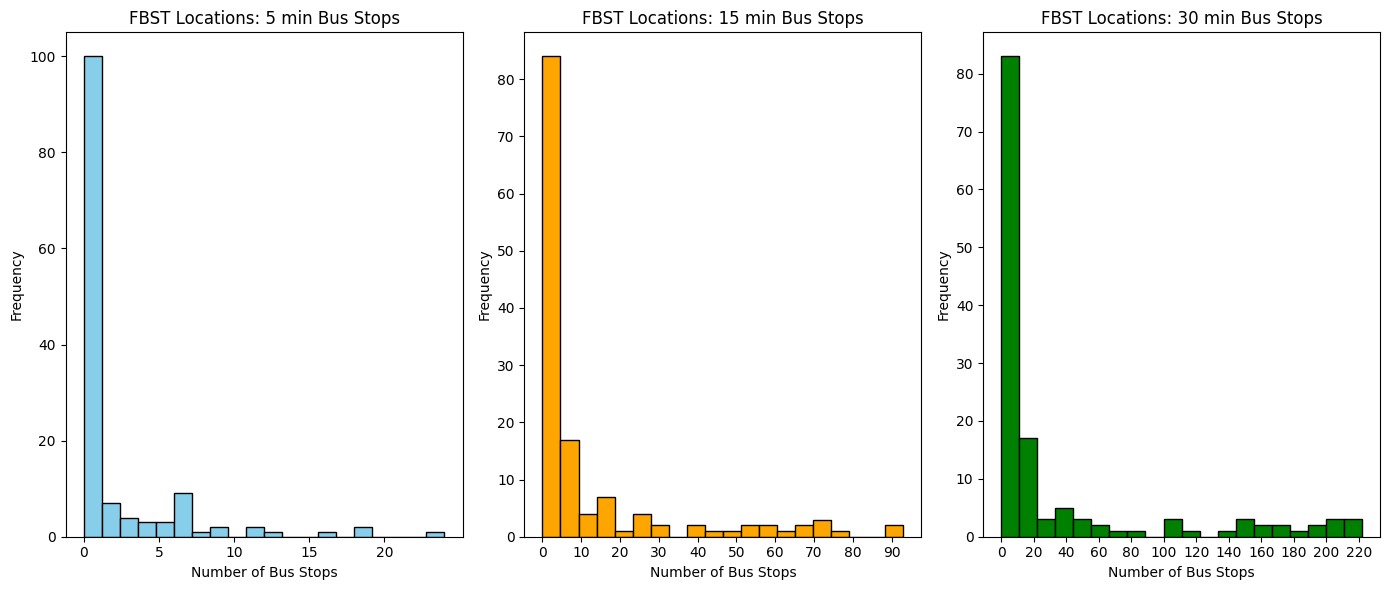

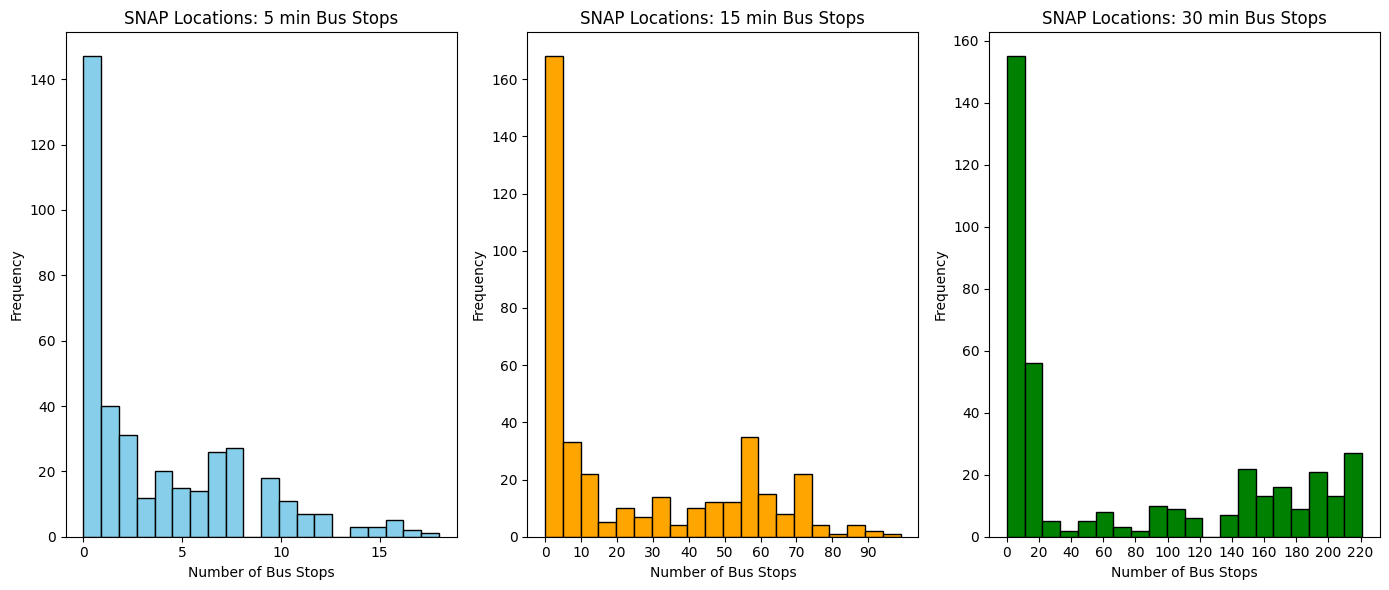

In [172]:
import pandas as pd
import matplotlib.pyplot as plt


# Plot histograms for FBST locations with labeled bins
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.hist(fbst_locations['5_min_bus_stops'], bins=20, color='skyblue', edgecolor='black')
plt.title('FBST Locations: 5 min Bus Stops')
plt.xlabel('Number of Bus Stops')
plt.ylabel('Frequency')
plt.xticks(range(0, int(fbst_locations['5_min_bus_stops'].max()) + 1, 5))

plt.subplot(1, 3, 2)
plt.hist(fbst_locations['15_min_bus_stops'], bins=20, color='orange', edgecolor='black')
plt.title('FBST Locations: 15 min Bus Stops')
plt.xlabel('Number of Bus Stops')
plt.ylabel('Frequency')
plt.xticks(range(0, int(fbst_locations['15_min_bus_stops'].max()) + 1, 10))

plt.subplot(1, 3, 3)
plt.hist(fbst_locations['30_min_bus_stops'], bins=20, color='green', edgecolor='black')
plt.title('FBST Locations: 30 min Bus Stops')
plt.xlabel('Number of Bus Stops')
plt.ylabel('Frequency')
plt.xticks(range(0, int(fbst_locations['30_min_bus_stops'].max()) + 1, 20))

plt.tight_layout()
plt.savefig('fbst_histograms_labeled.png')
plt.show()

# Plot histograms for SNAP locations with labeled bins
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.hist(snap_locations['5_min_bus_stops'], bins=20, color='skyblue', edgecolor='black')
plt.title('SNAP Locations: 5 min Bus Stops')
plt.xlabel('Number of Bus Stops')
plt.ylabel('Frequency')
plt.xticks(range(0, int(snap_locations['5_min_bus_stops'].max()) + 1, 5))

plt.subplot(1, 3, 2)
plt.hist(snap_locations['15_min_bus_stops'], bins=20, color='orange', edgecolor='black')
plt.title('SNAP Locations: 15 min Bus Stops')
plt.xlabel('Number of Bus Stops')
plt.ylabel('Frequency')
plt.xticks(range(0, int(snap_locations['15_min_bus_stops'].max()) + 1, 10))

plt.subplot(1, 3, 3)
plt.hist(snap_locations['30_min_bus_stops'], bins=20, color='green', edgecolor='black')
plt.title('SNAP Locations: 30 min Bus Stops')
plt.xlabel('Number of Bus Stops')
plt.ylabel('Frequency')
plt.xticks(range(0, int(snap_locations['30_min_bus_stops'].max()) + 1, 20))

plt.tight_layout()
plt.savefig('snap_histograms_labeled.png')
plt.show()


In [2]:
# read files 
 

#i have these two files give me code to do it they are in current dir so dont do overacting
#snap_locations_with_transitaccess.csv
#fbst_locations_with_transitaccess.csv

import pandas as pd

# read files 
snap_locations = pd.read_csv('snap_locations_with_transitaccess.csv')
fbst_locations = pd.read_csv('fbst_locations_with_transitaccess.csv')

# check columns 
print(snap_locations.columns)
print(fbst_locations.columns)

# columns 

"""Index(['Unnamed: 0', 'Record ID', 'Store Name', 'Store Type', 'Street Number',
       'Street Name', 'Additional Address', 'City', 'State', 'Zip Code',
       'Zip4', 'County', 'Latitude', 'Longitude', 'Authorization Date',
       'End Date', 'geometry', '5_min_bus_stops', '15_min_bus_stops',
       '30_min_bus_stops', 'bus_stop_within_15_min'],
      dtype='object')
Index(['Unnamed: 0', 'index', 'Loc ID', 'Agency #', 'Agency Name', 'MFP',
       'Type', 'Address', 'City', 'St', 'County', 'Zip', 'Latitude',
       'Longitude', 'Record ID', '5_min_bus_stops', '15_min_bus_stops',
       '30_min_bus_stops', 'bus_stop_within_15_min'],
      dtype='object')"""
      
# get county wise bus_stop_within_15_min percentage summary for SNAP locations
snap_locations['bus_stop_within_15_min'] = snap_locations['bus_stop_within_15_min'].astype(int)



snap_summary = snap_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()

# also total bus stops for each county and percentage of bus stops within 15 min, prettify percent, round *100
snap_summary['bus_stop_within_15_min_percentage'] = (snap_summary['bus_stop_within_15_min'] * 100).round(2)
snap_summary = snap_summary.sort_values('bus_stop_within_15_min_percentage', ascending=False)


snap_summary.columns = ['County', 'bus_stop_within_15_min_percentage']


Index(['Unnamed: 0', 'Record ID', 'Store Name', 'Store Type', 'Street Number',
       'Street Name', 'Additional Address', 'City', 'State', 'Zip Code',
       'Zip4', 'County', 'Latitude', 'Longitude', 'Authorization Date',
       'End Date', 'geometry', '5_min_bus_stops', '15_min_bus_stops',
       '30_min_bus_stops', 'bus_stop_within_15_min'],
      dtype='object')
Index(['Unnamed: 0', 'index', 'Loc ID', 'Agency #', 'Agency Name', 'MFP',
       'Type', 'Address', 'City', 'St', 'County', 'Zip', 'Latitude',
       'Longitude', 'Record ID', '5_min_bus_stops', '15_min_bus_stops',
       '30_min_bus_stops', 'bus_stop_within_15_min'],
      dtype='object')


,County,bus_stop_within_15_min_percentage
0,broome,0.817143
1,chemung,0.907407
2,schuyler,0.571429
3,steuben,0.303797
4,tioga,0.000000
5,tompkins,0.865672


In [5]:
import pandas as pd

# Read files
snap_locations = pd.read_csv('snap_locations_with_transitaccess.csv')
fbst_locations = pd.read_csv('fbst_locations_with_transitaccess.csv')

# Check columns
print(snap_locations.columns)
print(fbst_locations.columns)

# Ensure 'bus_stop_within_15_min' is of integer type for calculations
snap_locations['bus_stop_within_15_min'] = snap_locations['bus_stop_within_15_min'].astype(int)
fbst_locations['bus_stop_within_15_min'] = fbst_locations['bus_stop_within_15_min'].astype(int)

# Get county-wise bus_stop_within_15_min percentage summary for SNAP locations
snap_summary = snap_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
snap_summary['bus_stop_within_15_min_percentage'] = (snap_summary['bus_stop_within_15_min'] * 100).round(2)
snap_summary = snap_summary.sort_values('bus_stop_within_15_min_percentage', ascending=False)
snap_summary.columns = ['County', 'Bus Stop Within 15 Min Percentage (SNAP)']

# Print SNAP summary
print(snap_summary)

# Get county-wise bus_stop_within_15_min percentage summary for FBST locations
fbst_summary = fbst_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
fbst_summary['bus_stop_within_15_min_percentage'] = (fbst_summary['bus_stop_within_15_min'] * 100).round(2)
fbst_summary = fbst_summary.sort_values('bus_stop_within_15_min_percentage', ascending=False)
fbst_summary.columns = ['County', 'Bus Stop Within 15 Min Percentage (FBST)']

# Print FBST summary
print(fbst_summary)

# Merging both summaries for a combined output
combined_summary = pd.merge(snap_summary, fbst_summary, on='County', how='outer').fillna(0)

# Display the combined summary
print(combined_summary)

Index(['Unnamed: 0', 'Record ID', 'Store Name', 'Store Type', 'Street Number',
       'Street Name', 'Additional Address', 'City', 'State', 'Zip Code',
       'Zip4', 'County', 'Latitude', 'Longitude', 'Authorization Date',
       'End Date', 'geometry', '5_min_bus_stops', '15_min_bus_stops',
       '30_min_bus_stops', 'bus_stop_within_15_min'],
      dtype='object')
Index(['Unnamed: 0', 'index', 'Loc ID', 'Agency #', 'Agency Name', 'MFP',
       'Type', 'Address', 'City', 'St', 'County', 'Zip', 'Latitude',
       'Longitude', 'Record ID', '5_min_bus_stops', '15_min_bus_stops',
       '30_min_bus_stops', 'bus_stop_within_15_min'],
      dtype='object')


ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

In [10]:
import pandas as pd

# Read files
snap_locations = pd.read_csv('snap_locations_with_transitaccess.csv')
fbst_locations = pd.read_csv('fbst_locations_with_transitaccess.csv')

# Check columns
print(snap_locations.columns)
print(fbst_locations.columns)

# drop if fbst type is none  Type

fbst_locations = fbst_locations.dropna(subset=['Type'])

# Ensure 'bus_stop_within_15_min' is of integer type for calculations
snap_locations['bus_stop_within_15_min'] = snap_locations['bus_stop_within_15_min'].astype(int)
fbst_locations['bus_stop_within_15_min'] = fbst_locations['bus_stop_within_15_min'].astype(int)

# Get county-wise bus_stop_within_15_min percentage summary for SNAP locations
snap_summary = snap_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
snap_summary['bus_stop_within_15_min_percentage'] = (snap_summary['bus_stop_within_15_min'] * 100).round(2)
snap_summary = snap_summary.sort_values('bus_stop_within_15_min_percentage', ascending=False)

# Get county-wise bus_stop_within_15_min percentage summary for FBST locations
fbst_summary = fbst_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
fbst_summary['bus_stop_within_15_min_percentage'] = (fbst_summary['bus_stop_within_15_min'] * 100).round(2)
fbst_summary = fbst_summary.sort_values('bus_stop_within_15_min_percentage', ascending=False)

# Rename the columns for clarity
snap_summary.columns = ['County', 'bus_stop_within_15_min', 'Bus Stop Within 15 Min Percentage (SNAP)']
fbst_summary.columns = ['County', 'bus_stop_within_15_min', 'Bus Stop Within 15 Min Percentage (FBST)']

# Drop the intermediate 'bus_stop_within_15_min' column
snap_summary = snap_summary.drop(columns=['bus_stop_within_15_min'])
fbst_summary = fbst_summary.drop(columns=['bus_stop_within_15_min'])

# Print SNAP summary
print(snap_summary)

# Print FBST summary
print(fbst_summary)

# Merging both summaries for a combined output
combined_summary = pd.merge(snap_summary, fbst_summary, on='County', how='outer').fillna(0)

# Display the combined summary
print(combined_summary)


Index(['Unnamed: 0', 'Record ID', 'Store Name', 'Store Type', 'Street Number',
       'Street Name', 'Additional Address', 'City', 'State', 'Zip Code',
       'Zip4', 'County', 'Latitude', 'Longitude', 'Authorization Date',
       'End Date', 'geometry', '5_min_bus_stops', '15_min_bus_stops',
       '30_min_bus_stops', 'bus_stop_within_15_min'],
      dtype='object')
Index(['Unnamed: 0', 'index', 'Loc ID', 'Agency #', 'Agency Name', 'MFP',
       'Type', 'Address', 'City', 'St', 'County', 'Zip', 'Latitude',
       'Longitude', 'Record ID', '5_min_bus_stops', '15_min_bus_stops',
       '30_min_bus_stops', 'bus_stop_within_15_min'],
      dtype='object')
     County  Bus Stop Within 15 Min Percentage (SNAP)
1   chemung                                     90.74
5  tompkins                                     86.57
0    broome                                     81.71
2  schuyler                                     57.14
3   steuben                                     30.38
4     tioga    

,County,Bus Stop Within 15 Min Percentage (SNAP),Bus Stop Within 15 Min Percentage (FBST)
0,chemung,90.74,58.33
1,tompkins,86.57,81.82
2,broome,81.71,63.16
3,schuyler,57.14,100.00
4,steuben,30.38,24.39
5,tioga,0.00,0.00
6,delaware,0.00,0.00


In [9]:
# filter county as tioga in fbst 
fbst_locations[fbst_locations['County'] == 'tioga']

,Unnamed: 0,index,Loc ID,Agency #,Agency Name,MFP,Type,Address,City,St,County,Zip,Latitude,Longitude,Record ID,5_min_bus_stops,15_min_bus_stops,30_min_bus_stops,bus_stop_within_15_min
113,113,113,2175.0,20602,MFP Waverly,1.0,Christian - other,"40 STATE ROUTE 34, NORTH WAVERLY CHAPEL",WAVERLY,NY,tioga,14892,42.019213,-76.523814,NaN,NaN,NaN,NaN,0
114,114,114,2176.0,20603,MFP Richford,1.0,Congregationalist,13290 NY-38,Richford,NY,tioga,13736,42.355122,-76.200602,NaN,NaN,NaN,NaN,0
115,115,115,2177.0,20605,MFP TOI,1.0,Other,"9 SHELDON GUILE BLVD, TIOGA OPPORTUNITIES INC",OWEGO,NY,tioga,13827,42.113432,-76.270289,NaN,NaN,NaN,NaN,0
116,116,116,2178.0,20606,MFP Tioga County Rural Ministry,1.0,Christian - other,143 NORTH AVE,OWEGO,NY,tioga,13827,42.106796,-76.265451,NaN,NaN,NaN,NaN,0
117,117,117,2179.0,20607,MFP Apalachin,1.0,Catholic,"1110 PENNSYLVANIA AVE, ST. MARGARET MARY",APALACHIN,NY,tioga,13732,42.058850,-76.166657,NaN,NaN,NaN,NaN,0
118,118,118,2180.0,20610,MFP Nichols,1.0,Other,2384 W River Rd,NICHOLS,NY,tioga,13812,42.023938,-76.413133,NaN,NaN,NaN,NaN,0
119,119,119,2181.0,20611,"MFP Senior - Elizabeth Square, Waverly",1.0,Senior,430 FULTON ST,WAVERLY,NY,tioga,14892,42.001455,-76.541287,NaN,NaN,NaN,NaN,0
120,120,120,2182.0,20612,MFP Senior - Long Meadow Senior Housing,1.0,Senior,"5 BROWNS LN, LONG MEADOW APARTMENTS",OWEGO,NY,tioga,13827,42.112951,-76.270469,NaN,NaN,NaN,NaN,0
121,121,121,2311.0,20613,MFP Senior - Springview Apartments,1.0,Apartment,80 SPRING ST,WAVERLY,NY,tioga,14892,44.674035,-74.540936,NaN,NaN,NaN,NaN,0
122,122,122,3023.0,603,TOI - Bread of Life Food Pantry,NaN,Lutheran,1 Water St,CANDOR,NY,tioga,13743,42.227662,-76.338575,NaN,NaN,NaN,NaN,0


Index(['Unnamed: 0', 'Record ID', 'Store Name', 'Store Type', 'Street Number',
       'Street Name', 'Additional Address', 'City', 'State', 'Zip Code',
       'Zip4', 'County', 'Latitude', 'Longitude', 'Authorization Date',
       'End Date', 'geometry', '5_min_bus_stops', '15_min_bus_stops',
       '30_min_bus_stops', 'bus_stop_within_15_min'],
      dtype='object')
Index(['Unnamed: 0', 'index', 'Loc ID', 'Agency #', 'Agency Name', 'MFP',
       'Type', 'Address', 'City', 'St', 'County', 'Zip', 'Latitude',
       'Longitude', 'Record ID', '5_min_bus_stops', '15_min_bus_stops',
       '30_min_bus_stops', 'bus_stop_within_15_min'],
      dtype='object')
     County  Bus Stop Within 15 Min Percentage (SNAP)  \
0   chemung                                     90.74   
1  tompkins                                     86.57   
2    broome                                     81.71   
3  schuyler                                     57.14   
4   steuben                                     30.38 

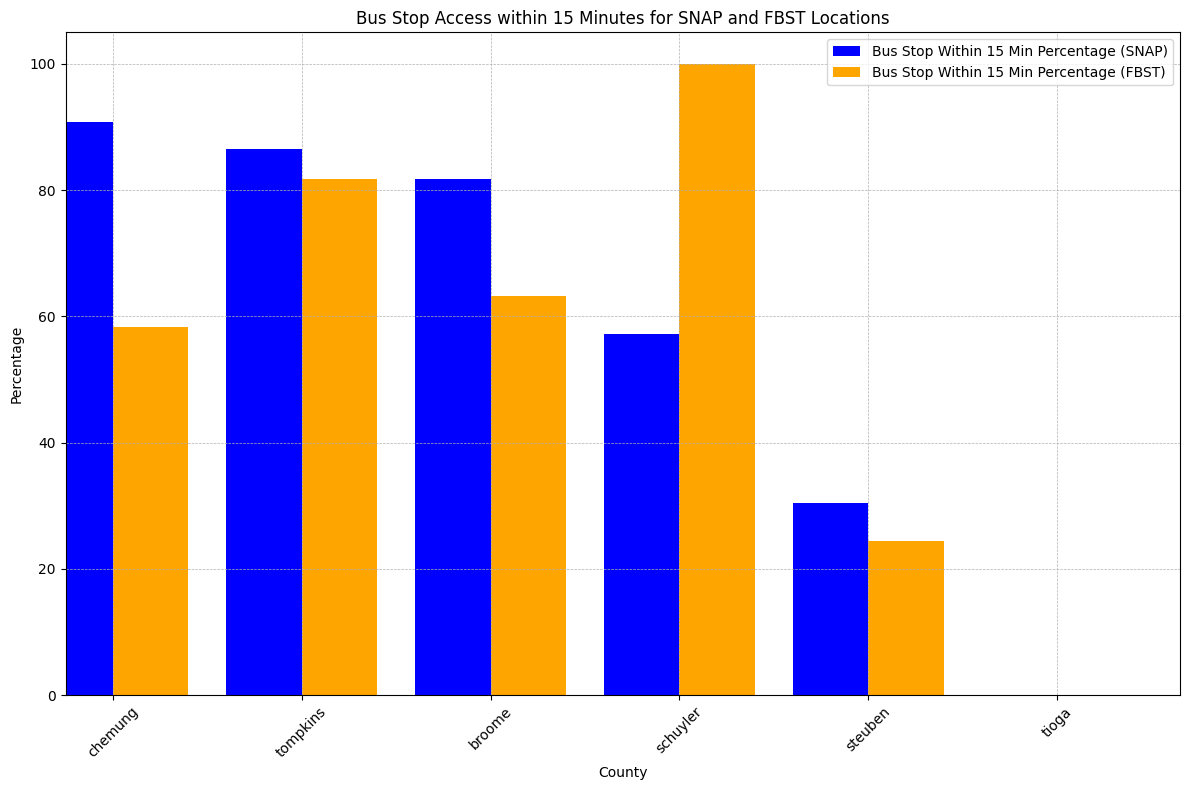

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Read files
snap_locations = pd.read_csv('snap_locations_with_transitaccess.csv')
fbst_locations = pd.read_csv('fbst_locations_with_transitaccess.csv')

# Check columns
print(snap_locations.columns)
print(fbst_locations.columns)

# Drop rows where FBST 'Type' is None
fbst_locations = fbst_locations.dropna(subset=['Type'])

# Ensure 'bus_stop_within_15_min' is of integer type for calculations
snap_locations['bus_stop_within_15_min'] = snap_locations['bus_stop_within_15_min'].astype(int)
fbst_locations['bus_stop_within_15_min'] = fbst_locations['bus_stop_within_15_min'].astype(int)

# Get county-wise bus_stop_within_15_min percentage summary for SNAP locations
snap_summary = snap_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
snap_summary['Bus Stop Within 15 Min Percentage (SNAP)'] = (snap_summary['bus_stop_within_15_min'] * 100).round(2)
snap_summary = snap_summary.drop(columns=['bus_stop_within_15_min']).sort_values('Bus Stop Within 15 Min Percentage (SNAP)', ascending=False)

# Get county-wise bus_stop_within_15_min percentage summary for FBST locations
fbst_summary = fbst_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
fbst_summary['Bus Stop Within 15 Min Percentage (FBST)'] = (fbst_summary['bus_stop_within_15_min'] * 100).round(2)
fbst_summary = fbst_summary.drop(columns=['bus_stop_within_15_min']).sort_values('Bus Stop Within 15 Min Percentage (FBST)', ascending=False)

# Drop 'Delaware' and set 'Tioga' to 0
snap_summary = snap_summary[snap_summary['County'] != 'delaware']
fbst_summary = fbst_summary[fbst_summary['County'] != 'delaware']

# Merging both summaries for a combined output
combined_summary = pd.merge(snap_summary, fbst_summary, on='County', how='outer').fillna(0)

# Set Tioga data to grey to indicate no data
combined_summary.loc[combined_summary['County'] == 'tioga', ['Bus Stop Within 15 Min Percentage (SNAP)', 'Bus Stop Within 15 Min Percentage (FBST)']] = 0

# Display the combined summary
print(combined_summary)

# Plotting the data
fig, ax = plt.subplots(figsize=(12, 8))

# Plot SNAP data
combined_summary.plot(kind='bar', x='County', y='Bus Stop Within 15 Min Percentage (SNAP)', ax=ax, color='blue', position=1, width=0.4)
# Plot FBST data
combined_summary.plot(kind='bar', x='County', y='Bus Stop Within 15 Min Percentage (FBST)', ax=ax, color='orange', position=0, width=0.4)

# Customizing plot
ax.set_title('Bus Stop Access within 15 Minutes for SNAP and FBST Locations')
ax.set_ylabel('Percentage')
ax.set_xlabel('County')
ax.legend(['Bus Stop Within 15 Min Percentage (SNAP)', 'Bus Stop Within 15 Min Percentage (FBST)'])
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as a file
plt.savefig('bus_stop_access_plot.png', dpi=300)
plt.show()


     County  Bus Stop Within 15 Min Percentage (SNAP)  Total SNAP Locations  \
0    Broome                                     81.71                   175   
1   Chemung                                     90.74                    54   
2  Schuyler                                     57.14                    14   
3   Steuben                                     30.38                    79   
4     Tioga                                      0.00                    27   
5  Tompkins                                     86.57                    67   

   Bus Stop Within 15 Min Percentage (FBST)  Total FBST Locations  
0                                     63.16                    38  
1                                     58.33                    24  
2                                    100.00                     8  
3                                     24.39                    41  
4                                      0.00                    20  
5                                     

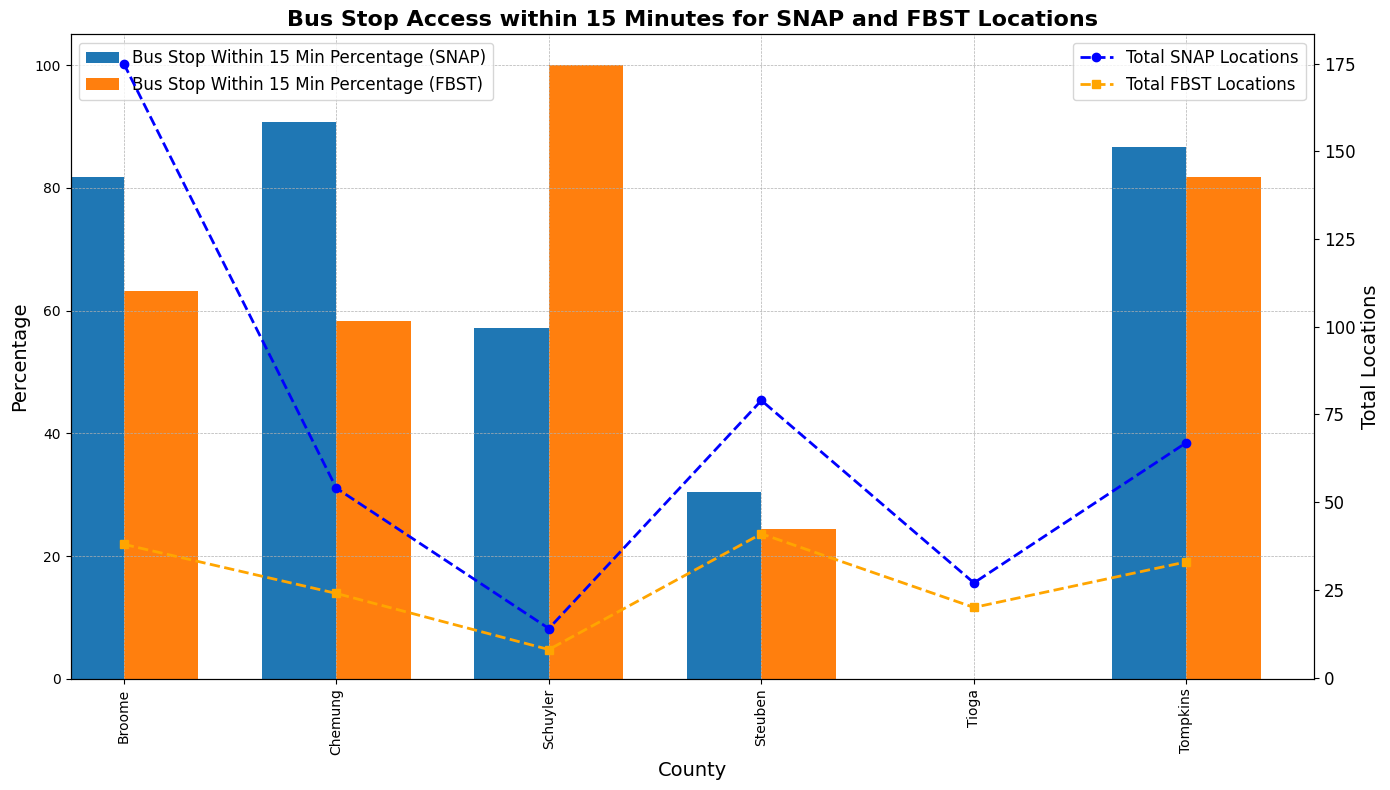

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Read files
snap_locations = pd.read_csv('snap_locations_with_transitaccess.csv')
fbst_locations = pd.read_csv('fbst_locations_with_transitaccess.csv')

# Drop rows where FBST 'Type' is None
fbst_locations = fbst_locations.dropna(subset=['Type'])

# Ensure 'bus_stop_within_15_min' is of integer type for calculations
snap_locations['bus_stop_within_15_min'] = snap_locations['bus_stop_within_15_min'].astype(int)
fbst_locations['bus_stop_within_15_min'] = fbst_locations['bus_stop_within_15_min'].astype(int)

# Get county-wise bus_stop_within_15_min percentage summary for SNAP locations
snap_summary = snap_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
snap_summary['Bus Stop Within 15 Min Percentage (SNAP)'] = (snap_summary['bus_stop_within_15_min'] * 100).round(2)
snap_summary['Total SNAP Locations'] = snap_locations.groupby('County').size().reset_index(name='Total')['Total']
snap_summary = snap_summary.drop(columns=['bus_stop_within_15_min']).sort_values('County')

# Get county-wise bus_stop_within_15_min percentage summary for FBST locations
fbst_summary = fbst_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
fbst_summary['Bus Stop Within 15 Min Percentage (FBST)'] = (fbst_summary['bus_stop_within_15_min'] * 100).round(2)
fbst_summary['Total FBST Locations'] = fbst_locations.groupby('County').size().reset_index(name='Total')['Total']
fbst_summary = fbst_summary.drop(columns=['bus_stop_within_15_min']).sort_values('County')

# Drop 'Delaware' and set 'Tioga' to 0
snap_summary = snap_summary[snap_summary['County'] != 'delaware']
fbst_summary = fbst_summary[fbst_summary['County'] != 'delaware']

# Merging both summaries for a combined output
combined_summary = pd.merge(snap_summary, fbst_summary, on='County', how='outer').fillna(0)

# Set Tioga data to grey to indicate no data
#combined_summary.loc[combined_summary['County'] == 'tioga', ['Bus Stop Within 15 Min Percentage (SNAP)', 'Bus Stop Within 15 Min Percentage (FBST)']] = 0

# Capitalize County names
combined_summary['County'] = combined_summary['County'].str.capitalize()

# Display the combined summary
print(combined_summary)

# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot SNAP and FBST data on primary y-axis
width = 0.35  # Width of the bars
combined_summary.plot(kind='bar', x='County', y='Bus Stop Within 15 Min Percentage (SNAP)', ax=ax1, color='#1f77b4', position=1, width=width)
combined_summary.plot(kind='bar', x='County', y='Bus Stop Within 15 Min Percentage (FBST)', ax=ax1, color='#ff7f0e', position=0, width=width)

# Create secondary y-axis for total locations
ax2 = ax1.twinx()

# Plot total SNAP locations on secondary y-axis
combined_summary.plot(kind='line', x='County', y='Total SNAP Locations', ax=ax2, color='blue', marker='o', linewidth=2, linestyle='--', legend=False)
# Plot total FBST locations on secondary y-axis
combined_summary.plot(kind='line', x='County', y='Total FBST Locations', ax=ax2, color='orange', marker='s', linewidth=2, linestyle='--', legend=False)

# Customizing plot
ax1.set_title('Bus Stop Access within 15 Minutes for SNAP and FBST Locations', fontsize=16, fontweight='bold')
ax1.set_ylabel('Percentage', fontsize=14)
ax1.set_xlabel('County', fontsize=14)
ax2.set_ylabel('Total Locations', fontsize=14)
ax1.legend(['Bus Stop Within 15 Min Percentage (SNAP)', 'Bus Stop Within 15 Min Percentage (FBST)'], fontsize=12, loc='upper left')
ax2.legend(['Total SNAP Locations', 'Total FBST Locations'], fontsize=12, loc='upper right')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot as a file
plt.savefig('bus_stop_access_plot.png', dpi=300)
plt.show()


     County  bus_stop_within_15_min_x  \
0    Broome                  0.817143   
1   Chemung                  0.907407   
2  Schuyler                  0.571429   
3   Steuben                  0.303797   
4     Tioga                  0.000000   
5  Tompkins                  0.865672   

   Bus Stop Within 15 Min Percentage (SNAP)  Total SNAP Locations  \
0                                     81.71                   175   
1                                     90.74                    54   
2                                     57.14                    14   
3                                     30.38                    79   
4                                      0.00                    27   
5                                     86.57                    67   

   bus_stop_within_15_min_y  Bus Stop Within 15 Min Percentage (FBST)  \
0                  0.631579                                     63.16   
1                  0.583333                                     58.33   
2        

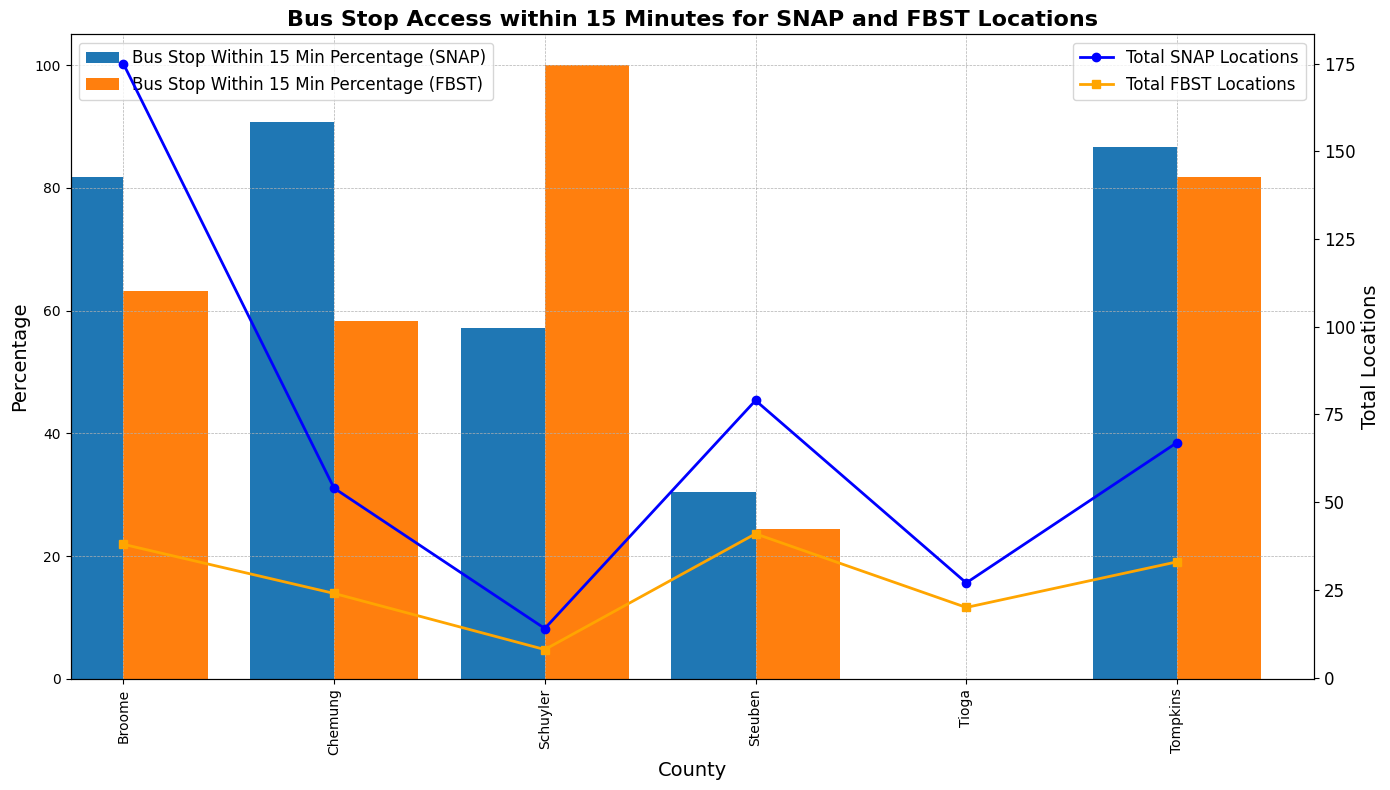

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Read files
snap_locations = pd.read_csv('snap_locations_with_transitaccess.csv')
fbst_locations = pd.read_csv('fbst_locations_with_transitaccess.csv')

# Drop rows where FBST 'Type' is None
fbst_locations = fbst_locations.dropna(subset=['Type'])

# Ensure 'bus_stop_within_15_min' is of integer type for calculations
snap_locations['bus_stop_within_15_min'] = snap_locations['bus_stop_within_15_min'].astype(int)
fbst_locations['bus_stop_within_15_min'] = fbst_locations['bus_stop_within_15_min'].astype(int)

# Get county-wise bus_stop_within_15_min percentage summary for SNAP locations
snap_summary = snap_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
snap_summary['Bus Stop Within 15 Min Percentage (SNAP)'] = (snap_summary['bus_stop_within_15_min'] * 100).round(2)
snap_summary['Total SNAP Locations'] = snap_locations.groupby('County').size().reset_index(name='Total')['Total']
#snap_summary = snap_summary.drop(columns=['bus_stop_within_15_min']).sort_values('County')

# Get county-wise bus_stop_within_15_min percentage summary for FBST locations
fbst_summary = fbst_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
fbst_summary['Bus Stop Within 15 Min Percentage (FBST)'] = (fbst_summary['bus_stop_within_15_min'] * 100).round(2)
fbst_summary['Total FBST Locations'] = fbst_locations.groupby('County').size().reset_index(name='Total')['Total']
#fbst_summary = fbst_summary.drop(columns=['bus_stop_within_15_min']).sort_values('County')

# Drop 'Delaware' and set 'Tioga' to 0
snap_summary = snap_summary[snap_summary['County'] != 'delaware']
fbst_summary = fbst_summary[fbst_summary['County'] != 'delaware']

# Merging both summaries for a combined output
combined_summary = pd.merge(snap_summary, fbst_summary, on='County', how='outer').fillna(0)

# Set Tioga data to grey to indicate no data
combined_summary.loc[combined_summary['County'] == 'tioga', ['Bus Stop Within 15 Min Percentage (SNAP)', 'Bus Stop Within 15 Min Percentage (FBST)']] = 0

# Capitalize County names
combined_summary['County'] = combined_summary['County'].str.capitalize()

# Display the combined summary
print(combined_summary)

# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot SNAP and FBST data on primary y-axis
width = 0.4  # Width of the bars
combined_summary.plot(kind='bar', x='County', y='Bus Stop Within 15 Min Percentage (SNAP)', ax=ax1, color='#1f77b4', width=width, position=1)
combined_summary.plot(kind='bar', x='County', y='Bus Stop Within 15 Min Percentage (FBST)', ax=ax1, color='#ff7f0e', width=width, position=0)

# Create secondary y-axis for total locations
ax2 = ax1.twinx()

# Plot total SNAP locations on secondary y-axis
combined_summary.plot(kind='line', x='County', y='Total SNAP Locations', ax=ax2, color='blue', marker='o', linewidth=2, linestyle='-', legend=False)
# Plot total FBST locations on secondary y-axis
combined_summary.plot(kind='line', x='County', y='Total FBST Locations', ax=ax2, color='orange', marker='s', linewidth=2, linestyle='-', legend=False)

# Customizing plot
ax1.set_title('Bus Stop Access within 15 Minutes for SNAP and FBST Locations', fontsize=16, fontweight='bold')
ax1.set_ylabel('Percentage', fontsize=14)
ax1.set_xlabel('County', fontsize=14)
ax2.set_ylabel('Total Locations', fontsize=14)
ax1.legend(['Bus Stop Within 15 Min Percentage (SNAP)', 'Bus Stop Within 15 Min Percentage (FBST)'], fontsize=12, loc='upper left')
ax2.legend(['Total SNAP Locations', 'Total FBST Locations'], fontsize=12, loc='upper right')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot as a file
plt.savefig('bus_stop_access_plot.png', dpi=300)
plt.show()


     County  Bus Stop Within 15 Min Percentage (SNAP)  Total SNAP Locations  \
0    Broome                                     81.71                   175   
1   Chemung                                     90.74                    54   
2  Schuyler                                     57.14                    14   
3   Steuben                                     30.38                    79   
4     Tioga                                      0.00                    27   
5  Tompkins                                     86.57                    67   

   Bus Stop Within 15 Min Percentage (FBST)  Total FBST Locations  
0                                     63.16                    38  
1                                     58.33                    24  
2                                    100.00                     8  
3                                     24.39                    41  
4                                      0.00                    20  
5                                     

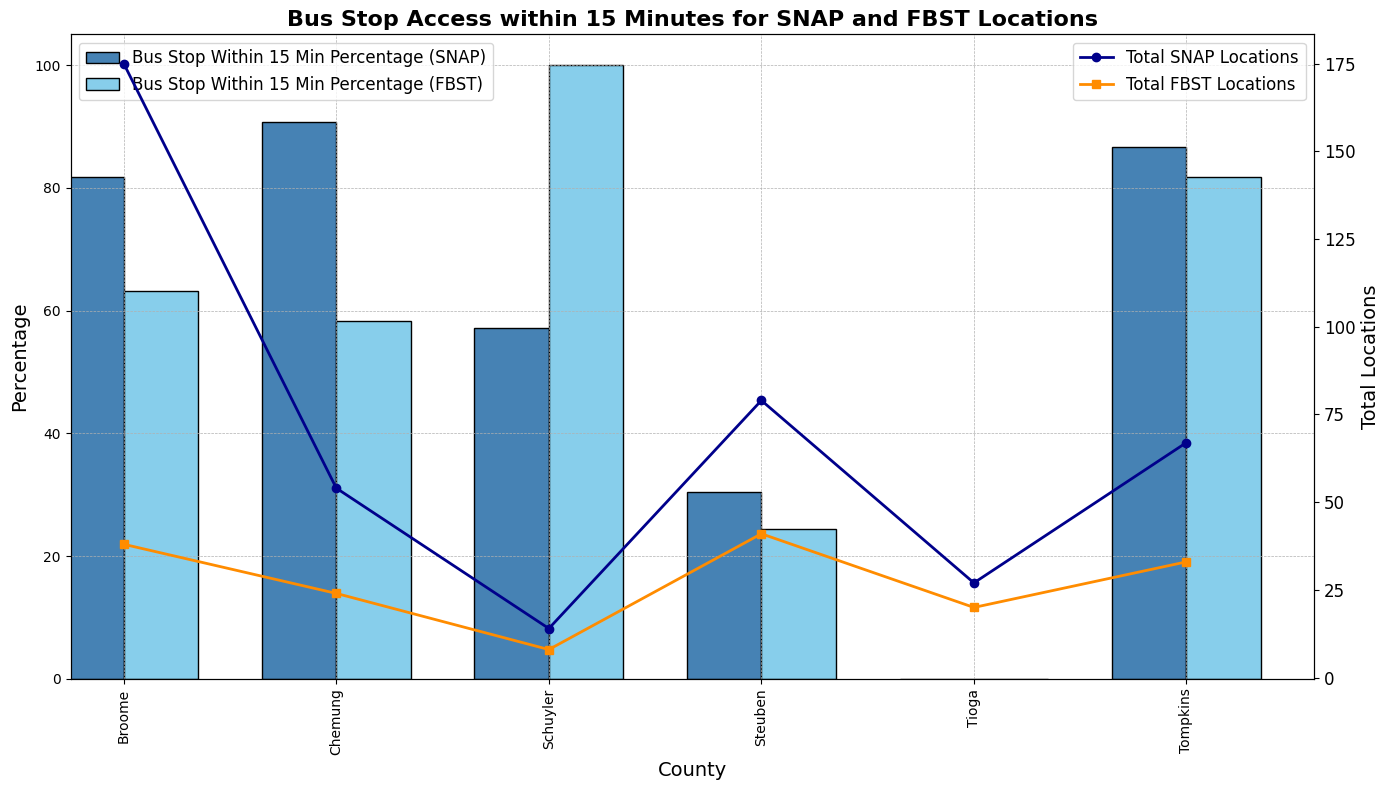

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Read files
snap_locations = pd.read_csv('snap_locations_with_transitaccess.csv')
fbst_locations = pd.read_csv('fbst_locations_with_transitaccess.csv')

# Drop rows where FBST 'Type' is None
fbst_locations = fbst_locations.dropna(subset=['Type'])

# Ensure 'bus_stop_within_15_min' is of integer type for calculations
snap_locations['bus_stop_within_15_min'] = snap_locations['bus_stop_within_15_min'].astype(int)
fbst_locations['bus_stop_within_15_min'] = fbst_locations['bus_stop_within_15_min'].astype(int)

# Get county-wise bus_stop_within_15_min percentage summary for SNAP locations
snap_summary = snap_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
snap_summary['Bus Stop Within 15 Min Percentage (SNAP)'] = (snap_summary['bus_stop_within_15_min'] * 100).round(2)
snap_summary['Total SNAP Locations'] = snap_locations.groupby('County').size().reset_index(name='Total')['Total']
snap_summary = snap_summary.drop(columns=['bus_stop_within_15_min']).sort_values('County')

# Get county-wise bus_stop_within_15_min percentage summary for FBST locations
fbst_summary = fbst_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
fbst_summary['Bus Stop Within 15 Min Percentage (FBST)'] = (fbst_summary['bus_stop_within_15_min'] * 100).round(2)
fbst_summary['Total FBST Locations'] = fbst_locations.groupby('County').size().reset_index(name='Total')['Total']
fbst_summary = fbst_summary.drop(columns=['bus_stop_within_15_min']).sort_values('County')

# Drop 'Delaware' and set 'Tioga' to 0
snap_summary = snap_summary[snap_summary['County'] != 'delaware']
fbst_summary = fbst_summary[fbst_summary['County'] != 'delaware']

# Merging both summaries for a combined output
combined_summary = pd.merge(snap_summary, fbst_summary, on='County', how='outer').fillna(0)

# Set Tioga data to grey to indicate no data
combined_summary.loc[combined_summary['County'] == 'tioga', ['Bus Stop Within 15 Min Percentage (SNAP)', 'Bus Stop Within 15 Min Percentage (FBST)']] = 0

# Capitalize County names
combined_summary['County'] = combined_summary['County'].str.capitalize()

# Display the combined summary
print(combined_summary)

# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot SNAP and FBST data on primary y-axis
width = 0.35  # Width of the bars
combined_summary.plot(kind='bar', x='County', y='Bus Stop Within 15 Min Percentage (SNAP)', ax=ax1, color='#4682B4', width=width, position=1, edgecolor='black')
combined_summary.plot(kind='bar', x='County', y='Bus Stop Within 15 Min Percentage (FBST)', ax=ax1, color='#87CEEB', width=width, position=0, edgecolor='black')

# Create secondary y-axis for total locations
ax2 = ax1.twinx()

# Plot total SNAP locations on secondary y-axis
combined_summary.plot(kind='line', x='County', y='Total SNAP Locations', ax=ax2, color='darkblue', marker='o', linewidth=2, linestyle='-', legend=False)
# Plot total FBST locations on secondary y-axis
combined_summary.plot(kind='line', x='County', y='Total FBST Locations', ax=ax2, color='darkorange', marker='s', linewidth=2, linestyle='-', legend=False)

# Customizing plot
ax1.set_title('Bus Stop Access within 15 Minutes for SNAP and FBST Locations', fontsize=16, fontweight='bold')
ax1.set_ylabel('Percentage', fontsize=14)
ax1.set_xlabel('County', fontsize=14)
ax2.set_ylabel('Total Locations', fontsize=14)
ax1.legend(['Bus Stop Within 15 Min Percentage (SNAP)', 'Bus Stop Within 15 Min Percentage (FBST)'], fontsize=12, loc='upper left')
ax2.legend(['Total SNAP Locations', 'Total FBST Locations'], fontsize=12, loc='upper right')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot as a file
plt.savefig('bus_stop_access_plot.png', dpi=300)
plt.show()


     County  Bus Stop Within 15 Min Percentage (SNAP)  Total SNAP Locations  \
0    Broome                                     81.71                   175   
1   Chemung                                     90.74                    54   
2  Schuyler                                     57.14                    14   
3   Steuben                                     30.38                    79   
4  Tompkins                                     86.57                    67   
5     Tioga                                      0.00                    27   

   Bus Stop Within 15 Min Percentage (FBST)  Total FBST Locations  
0                                     63.16                    38  
1                                     58.33                    24  
2                                    100.00                     8  
3                                     24.39                    41  
4                                     81.82                    33  
5                                     

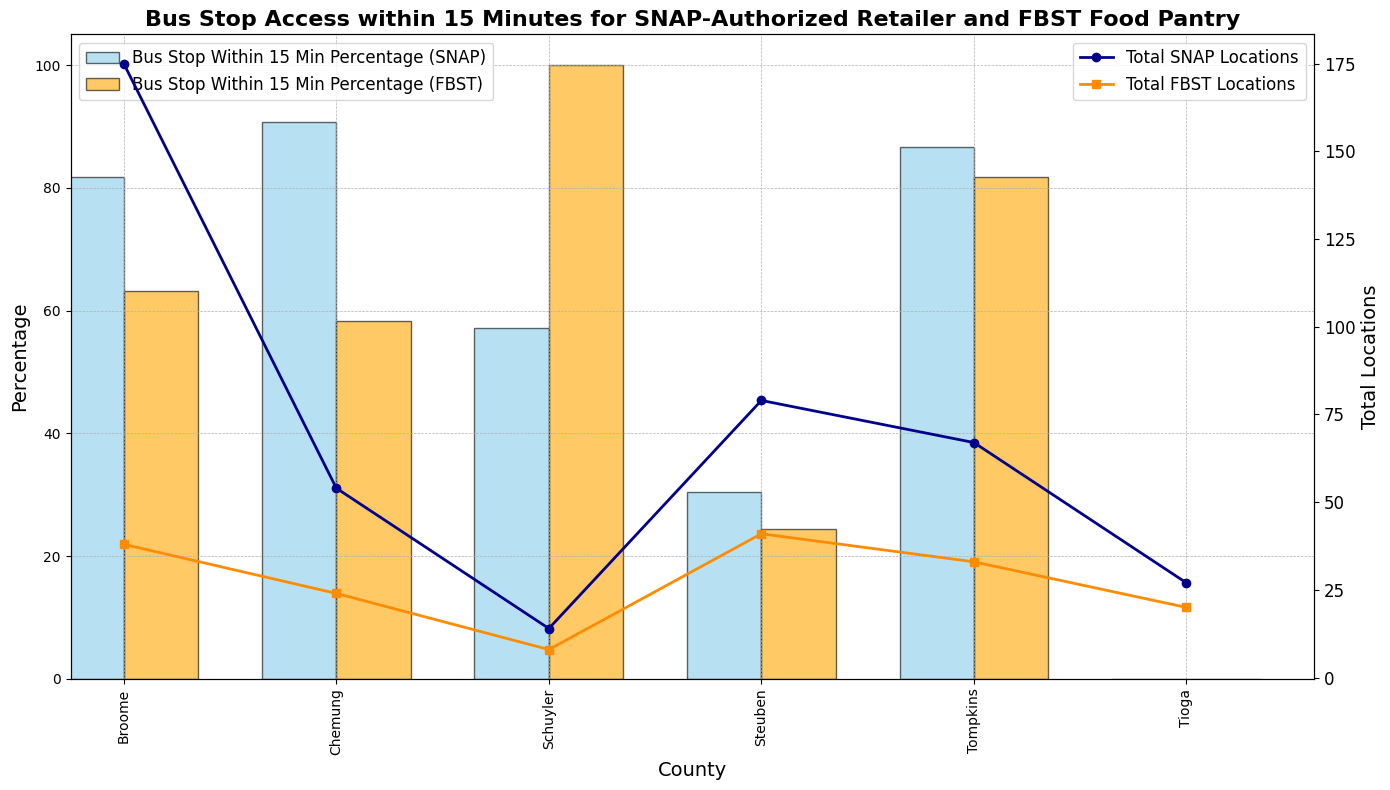

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Read files
snap_locations = pd.read_csv('snap_locations_with_transitaccess.csv')
fbst_locations = pd.read_csv('fbst_locations_with_transitaccess.csv')

# Drop rows where FBST 'Type' is None
fbst_locations = fbst_locations.dropna(subset=['Type'])

# Ensure 'bus_stop_within_15_min' is of integer type for calculations
snap_locations['bus_stop_within_15_min'] = snap_locations['bus_stop_within_15_min'].astype(int)
fbst_locations['bus_stop_within_15_min'] = fbst_locations['bus_stop_within_15_min'].astype(int)

# Get county-wise bus_stop_within_15_min percentage summary for SNAP locations
snap_summary = snap_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
snap_summary['Bus Stop Within 15 Min Percentage (SNAP)'] = (snap_summary['bus_stop_within_15_min'] * 100).round(2)
snap_summary['Total SNAP Locations'] = snap_locations.groupby('County').size().reset_index(name='Total')['Total']
snap_summary = snap_summary.drop(columns=['bus_stop_within_15_min']).sort_values('County')

# Get county-wise bus_stop_within_15_min percentage summary for FBST locations
fbst_summary = fbst_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
fbst_summary['Bus Stop Within 15 Min Percentage (FBST)'] = (fbst_summary['bus_stop_within_15_min'] * 100).round(2)
fbst_summary['Total FBST Locations'] = fbst_locations.groupby('County').size().reset_index(name='Total')['Total']
fbst_summary = fbst_summary.drop(columns=['bus_stop_within_15_min']).sort_values('County')

# Drop 'Delaware' and set 'Tioga' to 0
snap_summary = snap_summary[snap_summary['County'] != 'delaware']
fbst_summary = fbst_summary[fbst_summary['County'] != 'delaware']

# Merging both summaries for a combined output
combined_summary = pd.merge(snap_summary, fbst_summary, on='County', how='outer').fillna(0)

# Set Tioga data to grey to indicate no data
combined_summary.loc[combined_summary['County'] == 'Tioga', ['Bus Stop Within 15 Min Percentage (SNAP)', 'Bus Stop Within 15 Min Percentage (FBST)']] = 0

# Capitalize County names and ensure Tioga is at the end
combined_summary['County'] = combined_summary['County'].str.capitalize()
combined_summary = combined_summary.set_index('County').loc[[c for c in combined_summary['County'] if c != 'Tioga'] + ['Tioga']].reset_index()

# Display the combined summary
print(combined_summary)

# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot SNAP and FBST data on primary y-axis
width = 0.35  # Width of the bars
combined_summary.plot(kind='bar', x='County', y='Bus Stop Within 15 Min Percentage (SNAP)', ax=ax1, color='skyblue', alpha=0.6, width=width, position=1, edgecolor='black')
combined_summary.plot(kind='bar', x='County', y='Bus Stop Within 15 Min Percentage (FBST)', ax=ax1, color='orange',alpha=0.6, width=width, position=0, edgecolor='black')

# Create secondary y-axis for total locations
ax2 = ax1.twinx()

# Plot total SNAP locations on secondary y-axis
combined_summary.plot(kind='line', x='County', y='Total SNAP Locations', ax=ax2, color='#00008B', marker='o', linewidth=2, linestyle='-', legend=False)
# Plot total FBST locations on secondary y-axis
combined_summary.plot(kind='line', x='County', y='Total FBST Locations', ax=ax2, color='#FF8C00', marker='s', linewidth=2, linestyle='-', legend=False)

# Customizing plot
ax1.set_title('Bus Stop Access within 15 Minutes for SNAP-Authorized Retailer and FBST Food Pantry', fontsize=16, fontweight='bold')
ax1.set_ylabel('Percentage', fontsize=14)
ax1.set_xlabel('County', fontsize=14)
ax2.set_ylabel('Total Locations', fontsize=14)
ax1.legend(['Bus Stop Within 15 Min Percentage (SNAP)', 'Bus Stop Within 15 Min Percentage (FBST)'], fontsize=12, loc='upper left')
ax2.legend(['Total SNAP Locations', 'Total FBST Locations'], fontsize=12, loc='upper right')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot as a file
plt.savefig('bus_stop_access_plot.png', dpi=300)
plt.show()


In [23]:
combined_summary

,County,Bus Stop Within 15 Min Percentage (SNAP),Total SNAP Locations,Bus Stop Within 15 Min Percentage (FBST),Total FBST Locations
0,Broome,81.71,175,63.16,38
1,Chemung,90.74,54,58.33,24
2,Schuyler,57.14,14,100.00,8
3,Steuben,30.38,79,24.39,41
4,Tompkins,86.57,67,81.82,33
5,Tioga,0.00,27,0.00,20


     County  Bus Stop Within 15 Min Percentage (SNAP)  Total SNAP Locations  \
0    Broome                                     81.71                   175   
1   Chemung                                     90.74                    54   
2  Schuyler                                     57.14                    14   
3   Steuben                                     30.38                    79   
4  Tompkins                                     86.57                    67   
5     Tioga                                      0.00                    27   

   Bus Stop Within 15 Min Percentage (FBST)  Total FBST Locations  
0                                     63.16                    38  
1                                     58.33                    24  
2                                    100.00                     8  
3                                     24.39                    41  
4                                     81.82                    33  
5                                     

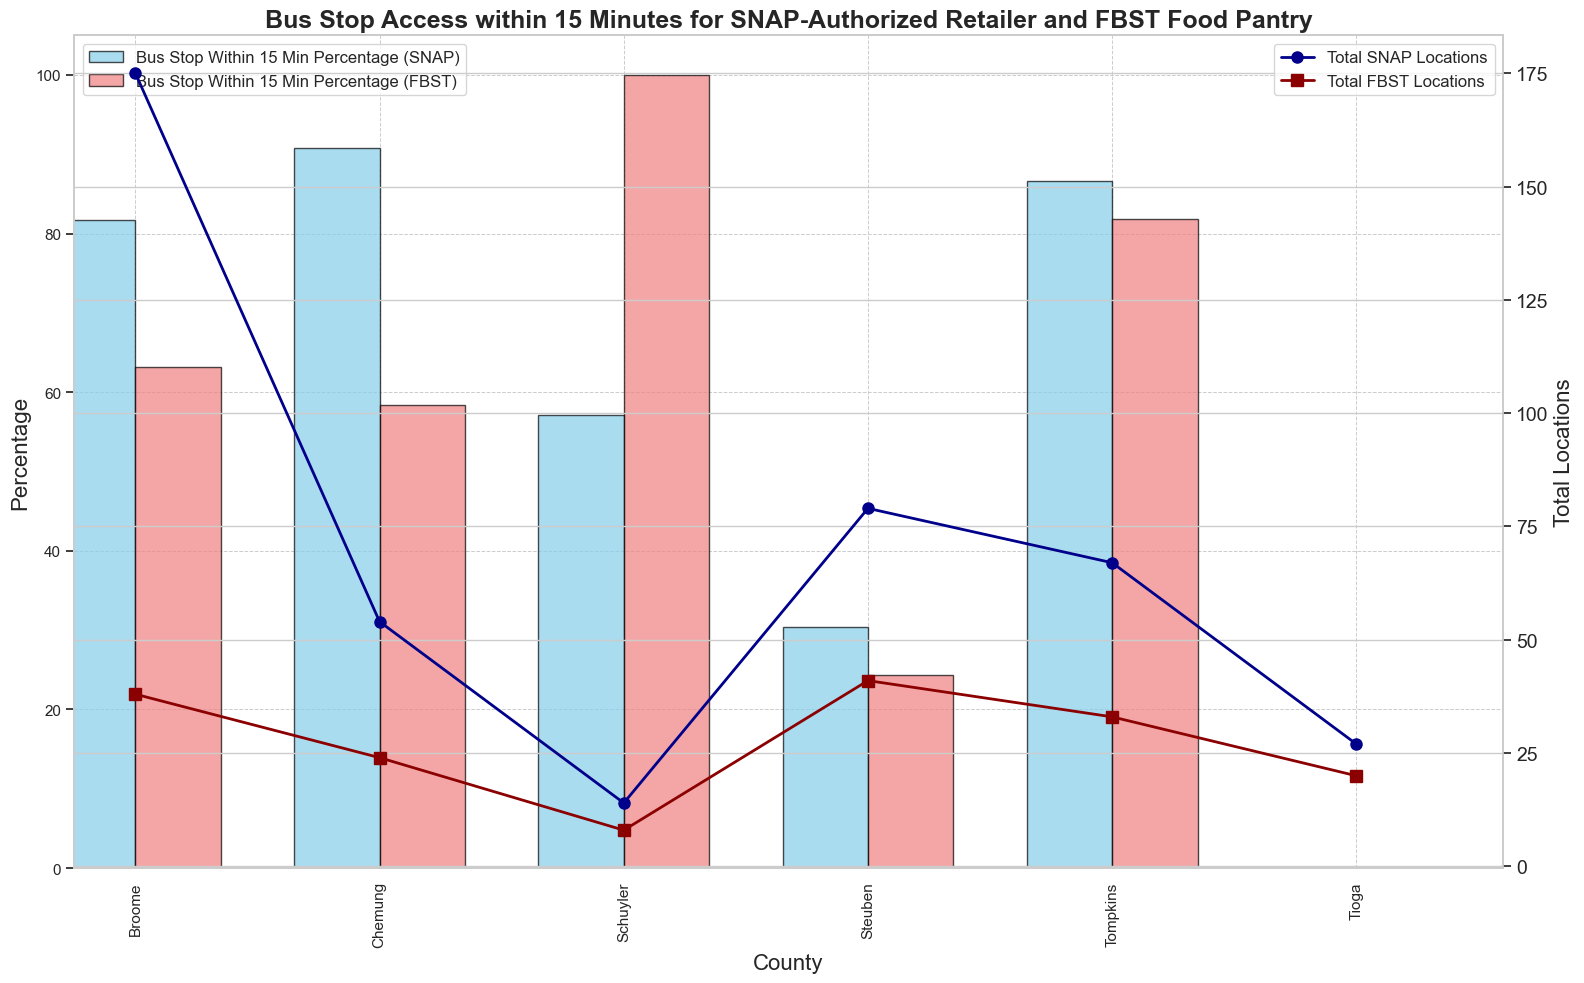

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read files
snap_locations = pd.read_csv('snap_locations_with_transitaccess.csv')
fbst_locations = pd.read_csv('fbst_locations_with_transitaccess.csv')

# Drop rows where FBST 'Type' is None
fbst_locations = fbst_locations.dropna(subset=['Type'])

# Ensure 'bus_stop_within_15_min' is of integer type for calculations
snap_locations['bus_stop_within_15_min'] = snap_locations['bus_stop_within_15_min'].astype(int)
fbst_locations['bus_stop_within_15_min'] = fbst_locations['bus_stop_within_15_min'].astype(int)

# Get county-wise bus_stop_within_15_min percentage summary for SNAP locations
snap_summary = snap_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
snap_summary['Bus Stop Within 15 Min Percentage (SNAP)'] = (snap_summary['bus_stop_within_15_min'] * 100).round(2)
snap_summary['Total SNAP Locations'] = snap_locations.groupby('County').size().reset_index(name='Total')['Total']
snap_summary = snap_summary.drop(columns=['bus_stop_within_15_min']).sort_values('County')

# Get county-wise bus_stop_within_15_min percentage summary for FBST locations
fbst_summary = fbst_locations.groupby('County')['bus_stop_within_15_min'].mean().reset_index()
fbst_summary['Bus Stop Within 15 Min Percentage (FBST)'] = (fbst_summary['bus_stop_within_15_min'] * 100).round(2)
fbst_summary['Total FBST Locations'] = fbst_locations.groupby('County').size().reset_index(name='Total')['Total']
fbst_summary = fbst_summary.drop(columns=['bus_stop_within_15_min']).sort_values('County')

# Drop 'Delaware' and set 'Tioga' to 0
snap_summary = snap_summary[snap_summary['County'] != 'delaware']
fbst_summary = fbst_summary[fbst_summary['County'] != 'delaware']

# Merging both summaries for a combined output
combined_summary = pd.merge(snap_summary, fbst_summary, on='County', how='outer').fillna(0)

# Set Tioga data to grey to indicate no data
combined_summary.loc[combined_summary['County'] == 'Tioga', ['Bus Stop Within 15 Min Percentage (SNAP)', 'Bus Stop Within 15 Min Percentage (FBST)']] = 0

# Capitalize County names and ensure Tioga is at the end
combined_summary['County'] = combined_summary['County'].str.capitalize()
combined_summary = combined_summary.set_index('County').loc[[c for c in combined_summary['County'] if c != 'Tioga'] + ['Tioga']].reset_index()

# Display the combined summary
print(combined_summary)

# Set the style
sns.set(style="whitegrid")

# Plotting the data
fig, ax1 = plt.subplots(figsize=(16, 10))

# Plot SNAP and FBST data on primary y-axis
width = 0.35  # Width of the bars
combined_summary.plot(kind='bar', x='County', y='Bus Stop Within 15 Min Percentage (SNAP)', ax=ax1, color='skyblue', alpha=0.7, width=width, position=1, edgecolor='black')
combined_summary.plot(kind='bar', x='County', y='Bus Stop Within 15 Min Percentage (FBST)', ax=ax1, color='lightcoral', alpha=0.7, width=width, position=0, edgecolor='black')

# Create secondary y-axis for total locations
ax2 = ax1.twinx()

# Plot total SNAP locations on secondary y-axis
combined_summary.plot(kind='line', x='County', y='Total SNAP Locations', ax=ax2, color='darkblue', marker='o', markersize=8, linewidth=2, linestyle='-', legend=False)
# Plot total FBST locations on secondary y-axis
combined_summary.plot(kind='line', x='County', y='Total FBST Locations', ax=ax2, color='darkred', marker='s', markersize=8, linewidth=2, linestyle='-', legend=False)

# Customizing plot
ax1.set_title('Bus Stop Access within 15 Minutes for SNAP-Authorized Retailer and FBST Food Pantry', fontsize=18, fontweight='bold')
ax1.set_ylabel('Percentage', fontsize=16)
ax1.set_xlabel('County', fontsize=16)
ax2.set_ylabel('Total Locations', fontsize=16)
ax1.legend(['Bus Stop Within 15 Min Percentage (SNAP)', 'Bus Stop Within 15 Min Percentage (FBST)'], fontsize=12, loc='upper left')
ax2.legend(['Total SNAP Locations', 'Total FBST Locations'], fontsize=12, loc='upper right')
ax1.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Save the plot as a file
plt.savefig('bus_stop_access_plot_high_quality.png', dpi=300)
plt.show()
